## Домашнее задание Numpy Neural Net Exploration (50 баллов)

В этом домашнем задании требуется провести набор экспериментов с нейронной сетью. Для проведения экспериментов нужно доработать представленный фреймворк для обучения нейронной сети на Numpy в проекте **Numpy_NN** c **hinge_loss** функцией ошибки. 

Ссылка на проект - https://github.com/runnerup96/Numpy-NN-Framework

Все необходимые доработки обозначены в проекте тегом **TODO**.

В ноутбуке только сами эксперименты с помощью данных команд - все доработки делать внутри фреймворка.

In [49]:
import glob
import pickle
import sys
import os
import importlib

In [50]:
sys.path.append(os.path.join(os.getcwd(), "src"))
import nn, dataset, optimization, training

In [51]:
import numpy as np
from sklearn.metrics import classification_report
from dataset import dataloader
from nn.module.sequential import Sequential
from nn.layers.linear import Linear
from nn.layers.batch_norm import BatchNorm
from nn.layers.dropout import Dropout
from nn.activations.relu import ReLU
from nn.activations.sigmoid import Sigmoid
from nn.activations.tanh import Tanh
from optimization.adam_optimizer import Adam
from nn import loss_functions
from training.train import train
import visualization_utils as viz_utils
from utils import progress_bar, gradient_check

Вам нужно провести набор экспериментов с CIFAR датасетом и исследовать поведение нейронной сети на этом датасете при разных архитектурах. Пример 1ого эксперимента можно найти в ноутбуке **test_CIFAR_training.py**

Ваши эксперименты должы быть логичны - старайтесь последовательно строить архитектуру и попытайтесь к концу эксприментов определить комбинацию компонент нейронной сети для лучшего качества. Также же вы можете расширять количеcтво экспериментов, подтверждая это соответсвующими выводами. 

В каждом эксперименте должен быть:
    
    * Процесс обучения нейронной сети с помощью training.train.train
    * Проверка градиента для каждой архитектуры нейронной сети с помощью utils.gradient_check(если это указано в описании эксперимента)
    * Визуализация обучения - воспользоваться методом visualization_utils.plot_learning_curves
    * Рассчет точности общей точности модели и рассчет по классовой точности с помощью sklearn.metrics.classification_report
    * Ваш вывод по результату эксперимента
    
В каждом эксперименте должен быть каждый пункт иначе эксперимент не оценивается. Каждый эксперимент оценивается в **4 балла**. За расширение пространства экспериментов и реализации своих идей можно дополнительно получить до **6 баллов**.

В данном ДЗ оценивается качество работы доработанного вами фреймворка, качество проведения эксперимента и полученный результат. 

## Предобработка данных

In [52]:
files = glob.glob("cifar-10-batches-py/**")
files = [item.split('/')[-1] for item in files]
for file in sorted(files):
    print(f"-{file}")

-batches.meta
-data_batch_1
-data_batch_2
-data_batch_3
-data_batch_4
-data_batch_5
-readme.html
-test_batch


In [53]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    train_dataset_1 = pickle.load(f, encoding="bytes")

In [54]:
for key in train_dataset_1.keys():
    print(f"-{key.decode('utf-8')}")

-batch_label
-labels
-data
-filenames


In [55]:
train_dataset_1[b'batch_label'].decode('utf-8')

'training batch 1 of 5'

In [56]:
print("Первые 10 названий:")
for name in train_dataset_1[b'filenames'][:10]:
    print(f"-{name.decode('utf-8')}")

Первые 10 названий:
-leptodactylus_pentadactylus_s_000004.png
-camion_s_000148.png
-tipper_truck_s_001250.png
-american_elk_s_001521.png
-station_wagon_s_000293.png
-coupe_s_001735.png
-cassowary_s_001300.png
-cow_pony_s_001168.png
-sea_boat_s_001584.png
-tabby_s_001355.png


In [57]:
print(train_dataset_1[b'labels'][:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


In [58]:
with open("cifar-10-batches-py/batches.meta", "rb") as f:
    classes_names = pickle.load(f, encoding="bytes")

for ind, name in enumerate(classes_names[b'label_names']):
    print(f"{ind}: {name.decode('utf-8')}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [59]:
print(f"Количество данных: {len(train_dataset_1[b'data'])}")
print(f"Размер вектора: {train_dataset_1[b'data'][0].shape}")

Количество данных: 10000
Размер вектора: (3072,)


In [60]:
with open("cifar-10-batches-py/data_batch_2", "rb") as f:
    train_dataset_2 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_3", "rb") as f:
    train_dataset_3 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_4", "rb") as f:
    train_dataset_4 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_5", "rb") as f:
    train_dataset_5 = pickle.load(f, encoding="bytes")

In [61]:
datasets = [train_dataset_1, train_dataset_2, train_dataset_3, 
            train_dataset_4, train_dataset_5]

labels = list(range(10))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|{8:^{9}}|{10:^{11}}|".format(
    "Data 1", 6, "Data 2", 6, "Data 3", 6, "Data 4", 6, "Data 5", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in datasets:
        print("{0:^{1}}|".format(dataset[b'labels'].count(label), 6), end='')
        label_num += dataset[b'labels'].count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|======|======|
|Label|Data 1|Data 2|Data 3|Data 4|Data 5| Sum  |
|=====|======|======|======|======|======|======|
|  0  | 1005 | 984  | 994  | 1003 | 1014 | 5000 |
|  1  | 974  | 1007 | 1042 | 963  | 1014 | 5000 |
|  2  | 1032 | 1010 | 965  | 1041 | 952  | 5000 |
|  3  | 1016 | 995  | 997  | 976  | 1016 | 5000 |
|  4  | 999  | 1010 | 990  | 1004 | 997  | 5000 |
|  5  | 937  | 988  | 1029 | 1021 | 1025 | 5000 |
|  6  | 1030 | 1008 | 978  | 1004 | 980  | 5000 |
|  7  | 1001 | 1026 | 1015 | 981  | 977  | 5000 |
|  8  | 1025 | 987  | 961  | 1024 | 1003 | 5000 |
|  9  | 981  | 985  | 1029 | 983  | 1022 | 5000 |
|=====|======|======|======|======|======|======|


In [62]:
train_dataset = []

for dataset in datasets:
    for vec, label in zip(dataset[b'data'], dataset[b'labels']):
        train_dataset.append((vec / 256, label))

In [63]:
np.random.seed(42)
np.random.shuffle(train_dataset)

train_data = []
valid_data = []

cnt = {ind: 0 for ind in range(10)}

for vec, label in train_dataset:
    if cnt[label] < 1000:
        cnt[label] += 1
        valid_data.append((vec, label))
    else:
        train_data.append((vec, label))

In [64]:
with open("cifar-10-batches-py/test_batch", "rb") as f:
    test_dataset = pickle.load(f, encoding="bytes")

test_data = []
for vec, label in zip(test_dataset[b'data'], test_dataset[b'labels']):
    test_data.append((vec / 256, label))

In [65]:
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|".format(
    "Train", 6, "Valid", 6, "Test", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

labels = list(range(10))
for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in (train_data, valid_data, test_data):
        labels_data = [item[1] for item in dataset]
        print("{0:^{1}}|".format(labels_data.count(label), 6), end='')
        label_num += labels_data.count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|
|Label|Train |Valid | Test | Sum  |
|=====|======|======|======|======|
|  0  | 4000 | 1000 | 1000 | 6000 |
|  1  | 4000 | 1000 | 1000 | 6000 |
|  2  | 4000 | 1000 | 1000 | 6000 |
|  3  | 4000 | 1000 | 1000 | 6000 |
|  4  | 4000 | 1000 | 1000 | 6000 |
|  5  | 4000 | 1000 | 1000 | 6000 |
|  6  | 4000 | 1000 | 1000 | 6000 |
|  7  | 4000 | 1000 | 1000 | 6000 |
|  8  | 4000 | 1000 | 1000 | 6000 |
|  9  | 4000 | 1000 | 1000 | 6000 |
|=====|======|======|======|======|


In [66]:
train_matrix = np.array([item[0] for item in train_data])
D = np.var(train_matrix, axis=0)
E = np.mean(train_matrix, axis=0)

for ind in range(len(train_data)):
    train_data[ind] = (train_data[ind][0] - E, train_data[ind][1])
    train_data[ind] = (train_data[ind][0] / np.sqrt(D), train_data[ind][1])

for ind in range(len(valid_data)):
    valid_data[ind] = (valid_data[ind][0] - E, valid_data[ind][1])
    valid_data[ind] = (valid_data[ind][0] / np.sqrt(D), valid_data[ind][1])

for ind in range(len(test_data)):
    test_data[ind] = (test_data[ind][0] - E, test_data[ind][1])
    test_data[ind] = (test_data[ind][0] / np.sqrt(D), test_data[ind][1])

In [67]:
class Start():
    def __init__(
        self,
        train_data, 
        valid_data, 
        model, 
        epochs: int, 
        lr: float = 1e-3, 
        optimizer: str = "Adam", 
        batch_size:int = 2000, 
        eps: float = 1e-3, 
        check_grads: bool = True,
        alpha1=None,
        alpha2=None
    ):
        self.train_data = train_data
        self.valid_data = valid_data
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.eps = eps
        self.check_grads = check_grads
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        
    def run_check_grad(self):
        print("Running check gradients...")
        print("_"*100)
        train_dataloader = dataloader.Dataloader(self.train_data, 100, False)
        for x, y in train_dataloader:
            break
        gradient_check(x, y, self.model, num_last=1, optim_method=self.optimizer, eps=1e-2)
        
    def train(self):
        print("Running training model...")
        print("_"*100)
        train_loss_history, valid_loss_history, train_acc_history, valid_acc_history = train(
        dataset=self.train_data,
        model=self.model,
        epochs=self.epochs,
        lr=self.lr,
        valid_dataset=self.valid_data,
        batch_size=self.batch_size,
        optim_method=self.optimizer, 
        alpha1=self.alpha1,
        alpha2=self.alpha2,
        )
        if self.check_grads:
            self.run_check_grad()
        return train_loss_history, valid_loss_history, train_acc_history, valid_acc_history
        
    def draw_training_curve(self, train_loss_history, valid_loss_history, train_acc_history, valid_acc_history):
        print("Drawing training curves...")
        print("_"*100)
        viz_utils.plot_learning_curves(
        train_loss_history, valid_loss_history,
        train_acc_history, valid_acc_history
        )
        
    def validate(self):
        print("Validation...")
        print("_"*100)
        test_dataloader = dataloader.Dataloader(test_data, 10000, False)
        self.model.eval()
        counter = test_loss = test_acc = 0
        
        for vecs, labels in test_dataloader:
            counter += 1
            out = self.model.forward(vecs)
            loss = loss_functions.hinge_loss.hinge_loss(out, labels)
            test_loss += loss.item()
            pred_labels = np.argmax(out.array, axis=-1)
            test_acc += np.sum(pred_labels == labels) / len(labels)
        test_loss /= counter
        test_acc /= counter

        print(f"Ошибка на тесте: {test_loss:.4f}")
        print(f"Точность на тесте: {test_acc:.4f}")
        return labels, pred_labels
        
    def get_classification_report(self, labels, pred_labels):
        print("getting classification report")
        print("_"*100)
        print(classification_report(labels, pred_labels))
        
    def run(self):
        train_loss_history, valid_loss_history, train_acc_history, valid_acc_history = self.train()
        self.draw_training_curve(train_loss_history, valid_loss_history, train_acc_history, valid_acc_history)
        labels, pred_labels = self.validate()
        self.get_classification_report(labels, pred_labels)

### Модель из ноутбука

Sequential(
	Linear(3072, 768, bias=True),
	Linear(768, 128, bias=True),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15| 13.0338  | 0.3023  | 13.3573  | 0.3002  | 0.003084 |   5.6    |   5.6    |
| 2/15|  7.0331  | 0.3233  |  7.2749  | 0.3126  | 0.001662 |   6.9    |   12.5   |
| 3/15|  5.3908  | 0.3555  |  5.8397  | 0.3406  | 0.001295 |   7.7    |   20.2   |
| 4/15|  5.2785  | 0.3755  |  5.3661  | 0.3620  | 0.000622 |   8.1    |   28.3   |
| 5/15|  4.2891  | 0.3795  |  5.1658  | 0.3590  | 0.000723 |   8.2    |   36.5   |
| 6/15|  4.5670  | 0.3853  |  4.9956  | 0.3541  | 0.000894 |   8.8    |   45.3   |
| 7/15|  4.6295  | 0.3877  |  4.8118  | 0.3588  | 0.001065 |   9.6    |   55.0   |
| 8/15|  4.4170  | 0.4047  |  4.6314  | 0.3704  | 0.000589 |   10.4   |   65.4   |
| 9/15|  4.1245  | 0.3953  |  4.7739  | 0.3

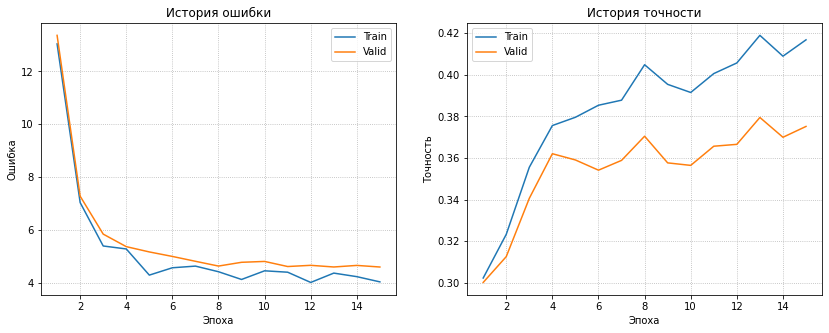

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 4.5788
Точность на тесте: 0.3804
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.40      0.47      0.43      1000
           1       0.47      0.41      0.44      1000
           2       0.27      0.30      0.28      1000
           3       0.28      0.26      0.27      1000
           4       0.32      0.31      0.32      1000
           5       0.34      0.24      0.28      1000
           6       0.43      0.45      0.44      1000
           7       0.42      0.41      0.42      1000
           8       0.46      0.47      0.46      1000
           9       0.41      0.47      0.44      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.38     10000


In [55]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    Linear(768, 128),
    Linear(128, 10)
)

display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

### Эксперимент 1 Построение нейронной сети с ReLU функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.3257  | 0.3590  |  5.5565  | 0.3444  | 0.005111 |   6.2    |   6.2    |
| 2/15|  4.2988  | 0.4365  |  4.3098  | 0.4002  | 0.003827 |   7.4    |   13.6   |
| 3/15|  3.6004  | 0.4726  |  4.0308  | 0.4242  | 0.002453 |   7.5    |   21.1   |
| 4/15|  3.2491  | 0.4955  |  3.9075  | 0.4288  | 0.002202 |   8.5    |   29.6   |
| 5/15|  2.6215  | 0.5375  |  3.6881  | 0.4484  | 0.000955 |   10.4   |   40.1   |
| 6/15|  2.4916  | 0.5712  |  3.6449  | 0.4606  | 0.001206 |   15.4   |   55.5   |
| 7/15|  2.2161  | 0.5857  |  3.5980  | 0.4589  | 0.000605 |   25.8   |   81.3   |
| 8/15|  2.2493  | 0.6199  |  3.5706  | 0.4630  | 0.000787 |   17.5   |   98.7   |
| 9/15|  1.8434  | 0.6413  |  3.4888  | 0.4

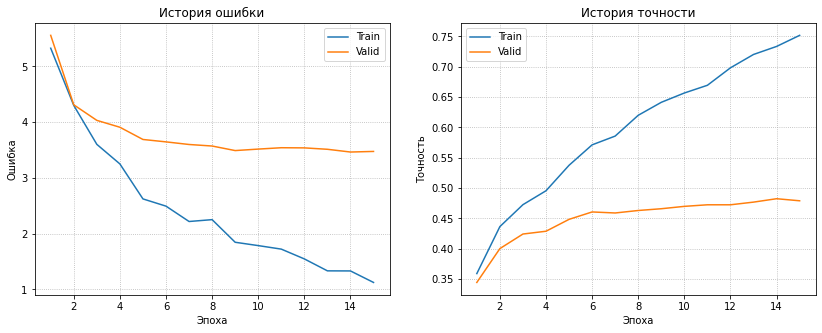

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4506
Точность на тесте: 0.4754
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.60      0.53      0.56      1000
           1       0.56      0.54      0.55      1000
           2       0.36      0.38      0.37      1000
           3       0.33      0.34      0.34      1000
           4       0.39      0.39      0.39      1000
           5       0.40      0.38      0.39      1000
           6       0.56      0.44      0.49      1000
           7       0.50      0.57      0.53      1000
           8       0.59      0.64      0.61      1000
           9       0.48      0.53      0.51      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000


In [56]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

display(model)
start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

Добавление слоёв с Relu улучшило результат

### Эксперимент 2 Построение нейронной сети с Sigmoid функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.    

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.1071  | 0.3515  |  4.8422  | 0.3428  | 0.015792 |   8.1    |   8.1    |
| 2/15|  4.4494  | 0.3948  |  4.3590  | 0.3851  | 0.012140 |   7.7    |   15.9   |
| 3/15|  3.7654  | 0.4224  |  4.1274  | 0.4028  | 0.010246 |   8.4    |   24.3   |
| 4/15|  4.0349  | 0.4389  |  3.9717  | 0.4188  | 0.009311 |   8.0    |   32.3   |
| 5/15|  3.8450  | 0.4500  |  3.8914  | 0.4238  | 0.007785 |   12.0   |   44.3   |
| 6/15|  3.5935  | 0.4655  |  3.7869  | 0.4361  | 0.006963 |   14.4   |   58.7   |
| 7/15|  3.5517  | 0.4803  |  3.7308  | 0.4430  | 0.004698 |   22.3   |   81.0   |
| 8/15|  3.3041  | 0.4900  |  3.6846  | 0.4440  | 0.005045 |   24.7   |  105.7   |
| 9/15|  3.2546  | 0.4993  |  3.6354  | 0.4

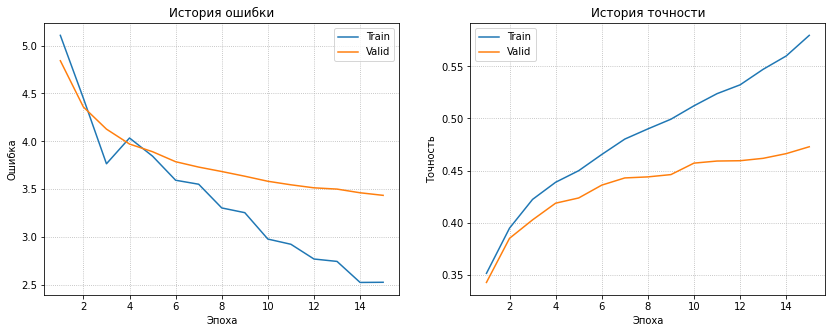

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4033
Точность на тесте: 0.4797
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.56      0.55      0.56      1000
           1       0.55      0.55      0.55      1000
           2       0.38      0.34      0.36      1000
           3       0.35      0.32      0.33      1000
           4       0.43      0.36      0.39      1000
           5       0.38      0.43      0.40      1000
           6       0.49      0.55      0.51      1000
           7       0.52      0.52      0.52      1000
           8       0.58      0.64      0.61      1000
           9       0.52      0.54      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000


In [57]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

Видно, что accuracy немного лучше, чем у сетки с слоями активации ReLu. Возможно, если увеличить число эпох или размер батча, то разница будет более заметной

### Эксперимент 3 Построение нейронной сети с TanH функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

Sequential(
	Linear(3072, 768, bias=True),
	Tanh(),
	Linear(768, 128, bias=True),
	Tanh(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.6549  | 0.3308  |  5.4157  | 0.3169  | 0.001714 |   8.0    |   8.0    |
| 2/15|  4.5972  | 0.3828  |  4.8459  | 0.3534  | 0.000733 |   8.1    |   16.1   |
| 3/15|  4.2381  | 0.4242  |  4.5961  | 0.3755  | 0.000760 |   8.4    |   24.5   |
| 4/15|  3.7622  | 0.4615  |  4.4322  | 0.3858  | 0.000464 |   8.3    |   32.8   |
| 5/15|  3.6131  | 0.4999  |  4.3209  | 0.4000  | 0.000402 |   8.4    |   41.2   |
| 6/15|  3.0864  | 0.5323  |  4.2227  | 0.4121  | 0.000339 |   8.7    |   49.8   |
| 7/15|  2.8349  | 0.5566  |  4.2118  | 0.4119  | 0.000371 |   8.6    |   58.4   |
| 8/15|  2.5822  | 0.5820  |  4.2126  | 0.4116  | 0.000337 |   9.3    |   67.7   |
| 9/15|  2.4993  | 0.6159  |  4.2151  | 0.4

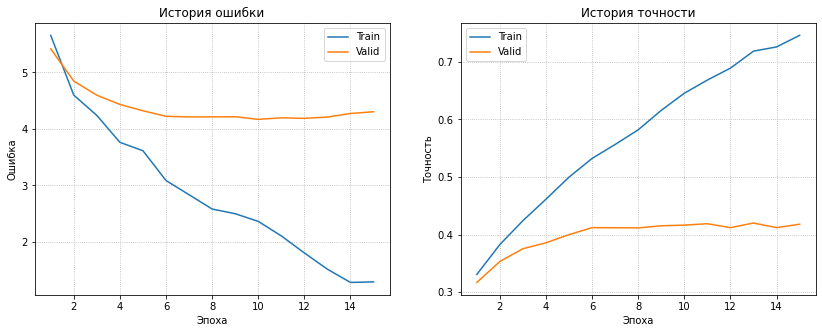

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 4.3051
Точность на тесте: 0.4214
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.52      0.48      0.50      1000
           1       0.50      0.44      0.47      1000
           2       0.33      0.29      0.31      1000
           3       0.29      0.22      0.25      1000
           4       0.34      0.41      0.37      1000
           5       0.35      0.33      0.34      1000
           6       0.44      0.50      0.47      1000
           7       0.43      0.42      0.42      1000
           8       0.56      0.59      0.57      1000
           9       0.44      0.52      0.48      1000

    accuracy                           0.42     10000
   macro avg       0.42      0.42      0.42     10000


In [59]:
model = Sequential(
    Linear(3072, 768),
    Tanh(),
    Linear(768, 128),
    Tanh(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

Видим, что accuracy хуже, чем у сеток со слоями активации ReLu или Sigmoid, но при этом лучше, чем у сетки без слоёв активации при том, что конечный train_accuracy у сетки с TanH значительно выше, чем у сетки с Sigmoid или без слоёв активации и только чуть хуже чем у сетки с ReLu

### Эксперимент 4 Построение нейронной сети с Dropout слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  Подберите оптимальную вероятность в dropout. 

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Dropout(p=0.2),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.4537  | 0.2827  |  5.9094  | 0.2820  | 0.004155 |   8.8    |   8.8    |
| 2/15|  5.0198  | 0.3194  |  5.2835  | 0.3154  | 0.002667 |   9.5    |   18.3   |
| 3/15|  4.5709  | 0.3467  |  4.9403  | 0.3427  | 0.001626 |   8.5    |   26.8   |
| 4/15|  4.0676  | 0.3645  |  4.7636  | 0.3535  | 0.002060 |   8.8    |   35.6   |
| 5/15|  4.0845  | 0.3814  |  4.6408  | 0.3670  | 0.002708 |   8.8    |   44.4   |
| 6/15|  4.0149  | 0.3941  |  4.5059  | 0.3786  | 0.002628 |   9.0    |   53.4   |
| 7/15|  3.7750  | 0.4068  |  4.4359  | 0.3867  | 0.001037 |   9.1    |   62.6   |
| 8/15|  3.8070  | 0.4133  |  4.3833  | 0.3884  | 0.001535 |   11.0   |   73.5   |
| 9/15|  3.6862  | 0.4194  |  4.3526  | 0.3

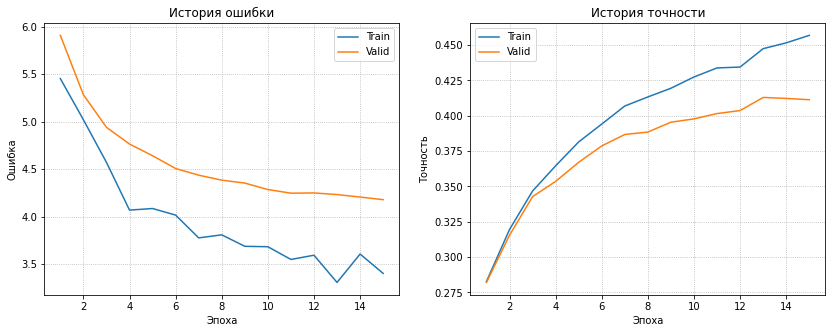

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 4.2205
Точность на тесте: 0.4103
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.50      0.41      0.45      1000
           1       0.65      0.34      0.45      1000
           2       0.32      0.32      0.32      1000
           3       0.28      0.35      0.31      1000
           4       0.40      0.30      0.35      1000
           5       0.43      0.16      0.23      1000
           6       0.37      0.65      0.48      1000
           7       0.48      0.44      0.46      1000
           8       0.40      0.74      0.52      1000
           9       0.52      0.39      0.45      1000

    accuracy                           0.41     10000
   macro avg       0.44      0.41      0.40     10000


In [60]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Dropout(0.2),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

Видно, что с добавлением drop out качество хуже, чем у аналогичной сетки (в плане у такой же сетки с слоями активации Sigmoid как и здесь, но без использования drop out)

### Эксперимент 5 Построение нейронной сети с Batchnorm слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 128, bias=True),
	Sigmoid(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  6.1174  | 0.3104  |  5.4429  | 0.3051  | 0.001522 |   10.7   |   10.7   |
| 2/15|  4.8586  | 0.3437  |  5.4122  | 0.3271  | 0.000669 |   9.7    |   20.4   |
| 3/15|  4.3238  | 0.3634  |  5.3636  | 0.3343  | 0.000504 |   10.0   |   30.3   |
| 4/15|  4.3919  | 0.3659  |  5.4970  | 0.3414  | 0.000538 |   9.9    |   40.2   |
| 5/15|  3.8654  | 0.3690  |  5.5880  | 0.3255  | 0.000307 |   10.5   |   50.8   |
| 6/15|  3.4878  | 0.3736  |  5.5576  | 0.3394  | 0.000391 |   11.2   |   62.0   |
| 7/15|  3.3146  | 0.3958  |  5.5722  | 0.3460  | 0.000367 |   11.0   |   73.0   |
| 8/15|  3.2510  | 0.4062  |  5.5696  | 0.3435  | 0.000390 |   12.8   |   85.8   |
| 9/15|  2.8278  | 0.4186  |  5.5716  | 0.3

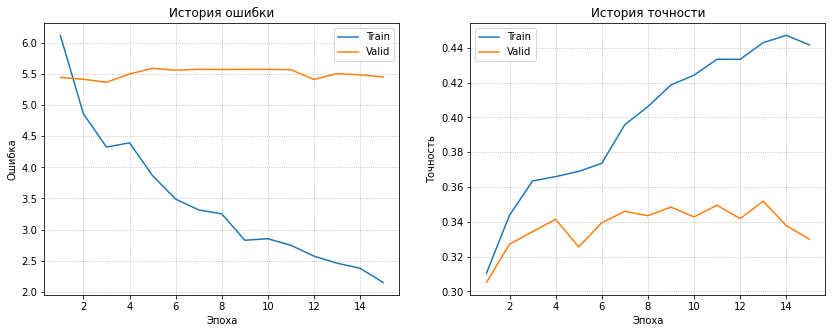

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 5.5902
Точность на тесте: 0.3028
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.36      0.59      0.44      1000
           1       0.59      0.16      0.26      1000
           2       0.26      0.32      0.28      1000
           3       0.18      0.32      0.23      1000
           4       0.21      0.62      0.31      1000
           5       0.35      0.22      0.27      1000
           6       0.48      0.14      0.21      1000
           7       0.50      0.33      0.40      1000
           8       0.75      0.09      0.17      1000
           9       0.61      0.24      0.34      1000

    accuracy                           0.30     10000
   macro avg       0.43      0.30      0.29     10000


In [61]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    BatchNorm(768),
    Linear(768, 128),
    Sigmoid(),
    BatchNorm(128),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

Accuracy значительно хуже даже чем у сетки без дополнительных слоёв, не говоря уже о сравнении с сеткой с слоями Sigmoid или с drop out. Заметим, что ошибка на валидационной выборке не меняется, а совершает совсем небольшие колебания около прямой вида y = 5.5, в то время как на тренировочной выборке loss падает, а точность на 15ой эпохе хуже, чем на 14ой и на трейне, и на валидационной выборке.

### Эксперимент 6 Эксперимент с Adam оптимизатором 

Обучите вашу нейронную сеть с Adam оптимизатором. Подбор гиперпараметров на ваше усмотрение. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

#### Без Adam

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  9.2280  | 0.1000  |  9.2369  | 0.1000  | 0.031081 |   6.4    |   6.4    |
| 2/15|  8.7391  | 0.1007  |  8.6968  | 0.1005  | 0.011150 |   7.2    |   13.6   |
| 3/15|  8.6476  | 0.1205  |  8.4278  | 0.1204  | 0.007549 |   7.0    |   20.6   |
| 4/15|  8.1748  | 0.1457  |  8.2180  | 0.1446  | 0.006318 |   8.0    |   28.6   |
| 5/15|  7.9717  | 0.1606  |  8.0199  | 0.1611  | 0.004814 |   7.1    |   35.7   |
| 6/15|  7.7093  | 0.1722  |  7.8323  | 0.1720  | 0.003543 |   7.3    |   43.0   |
| 7/15|  7.7271  | 0.1867  |  7.6561  | 0.1832  | 0.004716 |   7.9    |   50.9   |
| 8/15|  7.4275  | 0.2039  |  7.4905  | 0.1972  | 0.003192 |   8.2    |   59.1   |
| 9/15|  7.4065  | 0.2179  |  7.3388  | 0.2

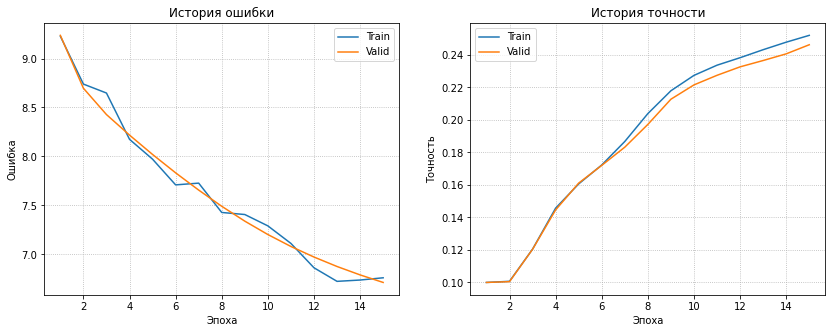

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 6.6897
Точность на тесте: 0.2549
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.29      0.49      0.36      1000
           1       0.32      0.22      0.26      1000
           2       0.14      0.02      0.03      1000
           3       0.15      0.28      0.20      1000
           4       0.15      0.01      0.03      1000
           5       0.44      0.09      0.15      1000
           6       0.21      0.46      0.29      1000
           7       0.21      0.18      0.19      1000
           8       0.42      0.35      0.38      1000
           9       0.31      0.45      0.36      1000

    accuracy                           0.25     10000
   macro avg       0.26      0.25      0.23     10000


In [62]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, optimizer="GD", batch_size=3000)
start_train.run()

#### с Adam

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  4.6583  | 0.3574  |  4.7880  | 0.3484  | 0.008004 |   7.9    |   7.9    |                                                ] 0/1 0s>0s
| 2/15|  4.2806  | 0.3943  |  4.3338  | 0.3838  | 0.004331 |   7.8    |   15.7   |
| 3/15|  3.8867  | 0.4153  |  4.1142  | 0.4034  | 0.005276 |   8.2    |   23.9   |
| 4/15|  3.7365  | 0.4387  |  3.9563  | 0.4203  | 0.005353 |   8.0    |   31.9   |
| 5/15|  3.5698  | 0.4535  |  3.8521  | 0.4280  | 0.003925 |   9.6    |   41.6   |
| 6/15|  3.4156  | 0.4656  |  3.7682  | 0.4357  | 0.005966 |   10.9   |   52.4   |
| 7/15|  3.4279  | 0.4786  |  3.7053  | 0.4444  | 0.002938 |   11.4   |   63.9   |
| 8/15|  3.1279  | 0.4869  |  3.6760  | 0.4465  | 0.002812 |   11.2

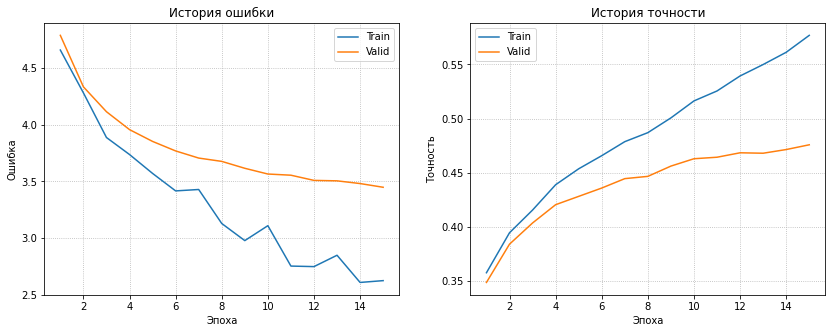

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4499
Точность на тесте: 0.4765
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.59      0.51      0.55      1000
           1       0.60      0.51      0.55      1000
           2       0.40      0.32      0.35      1000
           3       0.33      0.33      0.33      1000
           4       0.44      0.36      0.40      1000
           5       0.40      0.41      0.40      1000
           6       0.47      0.59      0.53      1000
           7       0.50      0.52      0.51      1000
           8       0.56      0.65      0.60      1000
           9       0.48      0.56      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000


In [63]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, optimizer="Adam", batch_size=3000)
start_train.run()

С оптимизатором Adam точность почти в 2 раза лучше, чем без Adam. Оно и очевидно, так как с Adam модель сходится значительно быстрее и градиент не застревает в локальных минимумах или седловых точках

### Эксперимент 7 Эксперимент c количеством слоев

Зафиксируйте модель и начинайте добавлять слои. Как меняется качество модели?

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  5.3767  | 0.3676  |  5.0930  | 0.3600  | 0.006518 |   8.9    |   8.9    |
| 2/30|  4.5234  | 0.4089  |  4.4584  | 0.3882  | 0.009977 |   7.4    |   16.3   |
| 3/30|  3.9284  | 0.4427  |  4.2452  | 0.4115  | 0.008938 |   7.7    |   24.0   |
| 4/30|  3.7268  | 0.4622  |  4.1195  | 0.4213  | 0.009034 |   7.7    |   31.8   |
| 5/30|  3.5582  | 0.4810  |  4.0607  | 0.4256  | 0.009197 |   8.0    |   39.8   |
| 6/30|  3.4560  | 0.4927  |  4.0571  | 0.4301  | 0.004892 |   7.9    |   47.6   |
| 7/30|  3.2848  | 0.5118  |  4.0173  | 0.4323  | 0.006089 |   8.0    |   55.7   |
| 8/30|  3.3048  | 0.5165  |  4.0038  | 0.4322  | 0.005587 |   7.9    |   63.6   |
| 9/30|  3.0058  | 0.5393  |  3.9665  | 0.4

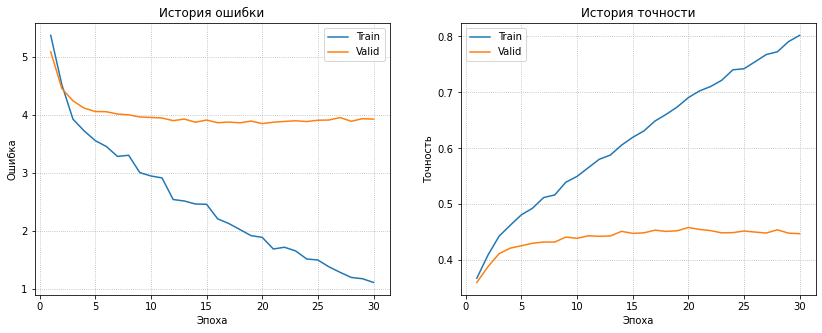

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.9142
Точность на тесте: 0.4571
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.53      0.56      0.54      1000
           1       0.57      0.49      0.53      1000
           2       0.35      0.33      0.34      1000
           3       0.31      0.31      0.31      1000
           4       0.40      0.33      0.36      1000
           5       0.35      0.37      0.36      1000
           6       0.47      0.55      0.51      1000
           7       0.48      0.47      0.48      1000
           8       0.58      0.64      0.61      1000
           9       0.52      0.53      0.52      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000


In [65]:
model = Sequential(
    Linear(3072, 768),
   Sigmoid(),
    Linear(768, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, optimizer="Adam", batch_size=3000)
start_train.run()

Sequential(
	Linear(3072, 512, bias=True),
	Sigmoid(),
	Linear(512, 256, bias=True),
	Sigmoid(),
	Linear(256, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  5.6074  | 0.3127  |  5.3867  | 0.3119  | 0.005505 |   8.4    |   8.4    |
| 2/30|  5.0670  | 0.3547  |  4.7935  | 0.3523  | 0.004231 |   6.6    |   15.0   |
| 3/30|  4.3695  | 0.3833  |  4.4312  | 0.3745  | 0.002074 |   6.5    |   21.5   |
| 4/30|  4.1623  | 0.4024  |  4.2426  | 0.3879  | 0.001048 |   6.7    |   28.2   |
| 5/30|  4.0472  | 0.4148  |  4.1271  | 0.3943  | 0.001850 |   6.6    |   34.8   |
| 6/30|  3.8115  | 0.4315  |  3.9945  | 0.4073  | 0.001479 |   6.8    |   41.6   |
| 7/30|  3.7536  | 0.4446  |  3.9152  | 0.4149  | 0.001816 |   6.7    |   48.3   |
| 8/30|  3.5784  | 0.4555  |  3.8514  | 0.4232  | 0.001683 |   6.8    |   55.2   |
| 9/30|  3.4762  | 0.4693  |  3.7632  | 0.4

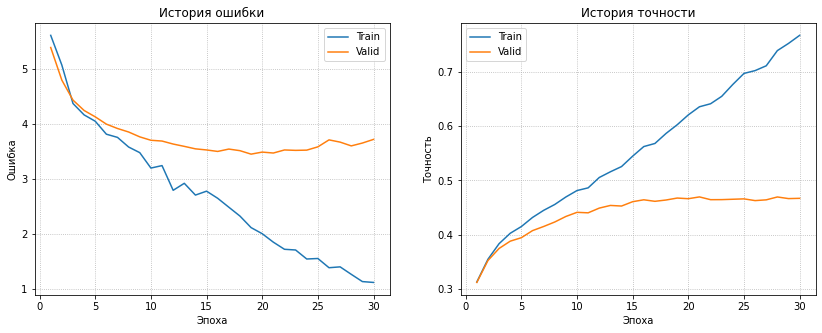

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.7933
Точность на тесте: 0.4555
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.57      0.47      0.51      1000
           1       0.60      0.52      0.55      1000
           2       0.32      0.35      0.34      1000
           3       0.33      0.27      0.29      1000
           4       0.38      0.39      0.38      1000
           5       0.33      0.47      0.39      1000
           6       0.48      0.54      0.51      1000
           7       0.56      0.43      0.49      1000
           8       0.54      0.65      0.59      1000
           9       0.56      0.47      0.51      1000

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.46     10000


In [66]:
model = Sequential(
    Linear(3072, 512),
    Sigmoid(),
    Linear(512, 256),
    Sigmoid(),
    Linear(256, 128),
    Sigmoid(),
    Linear(128, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, optimizer="Adam", batch_size=3000)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  4.8549  | 0.3630  |  4.7164  | 0.3566  | 0.008062 |   8.2    |   8.2    |
| 2/30|  4.3587  | 0.3957  |  4.3102  | 0.3795  | 0.004993 |   9.8    |   18.0   |
| 3/30|  4.0119  | 0.4212  |  4.0869  | 0.4014  | 0.005630 |   10.4   |   28.4   |
| 4/30|  3.8661  | 0.4392  |  3.9280  | 0.4195  | 0.002406 |   10.8   |   39.2   |
| 5/30|  3.6703  | 0.4556  |  3.8252  | 0.4297  | 0.003715 |   11.9   |   51.0   |
| 6/30|  3.4859  | 0.4677  |  3.7497  | 0.4374  | 0.002169 |   13.1   |   64.2   |
| 7/30|  3.4526  | 0.4785  |  3.6802  | 0.4450  | 0.002277 |   14.5   |   78.7   |
| 8/30|  3.3993  | 0.4903  |  3.6326  | 0.4498  | 0.001781 |   16.5   |   95.2   |
| 9/30|  3.0088  | 0.5004  |  3.5786  | 0.4

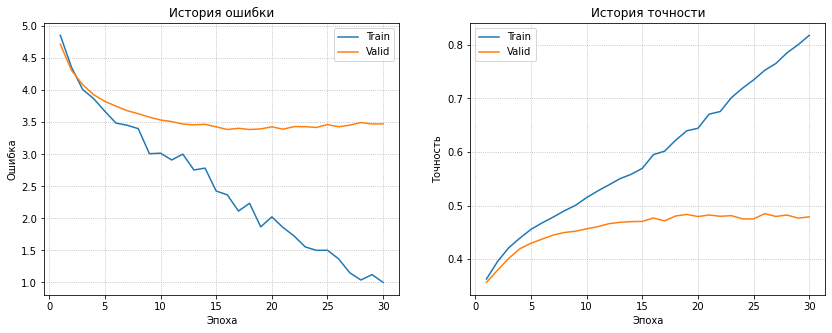

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4924
Точность на тесте: 0.4855
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.60      0.52      0.55      1000
           1       0.66      0.51      0.57      1000
           2       0.36      0.41      0.38      1000
           3       0.33      0.37      0.35      1000
           4       0.42      0.38      0.40      1000
           5       0.42      0.38      0.40      1000
           6       0.52      0.54      0.53      1000
           7       0.52      0.52      0.52      1000
           8       0.57      0.69      0.62      1000
           9       0.52      0.54      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000


In [67]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, optimizer="Adam", batch_size=3000)
start_train.run()

Видно, что лучшая точность у модели с двумя слоями, а худшая у модели с тремя слоями активации, но при этом у модели с одним слоем активации точность почти такая же, как с тремя.

### Эксперимент 8 Эксперимент c количеством нейронов

Зафиксируйте модель и увеличьте количетсво весов в одном из слоев. Дает ли это прирост качества?

Sequential(
	Linear(3072, 1536, bias=True),
	Sigmoid(),
	Linear(1536, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  4.8844  | 0.3698  |  4.7048  | 0.3606  | 0.018657 |   17.3   |   17.3   |
| 2/30|  4.2220  | 0.4029  |  4.2262  | 0.3894  | 0.008125 |   13.7   |   31.0   |
| 3/30|  4.1921  | 0.4310  |  4.0118  | 0.4098  | 0.010814 |   14.7   |   45.7   |
| 4/30|  3.6590  | 0.4487  |  3.8591  | 0.4240  | 0.005284 |   14.6   |   60.4   |
| 5/30|  3.4297  | 0.4627  |  3.7561  | 0.4309  | 0.004900 |   15.1   |   75.5   |
| 6/30|  3.4234  | 0.4784  |  3.6696  | 0.4442  | 0.006101 |   26.6   |  102.1   |
| 7/30|  3.3206  | 0.4983  |  3.5886  | 0.4534  | 0.003682 |   34.2   |  136.3   |
| 8/30|  3.3689  | 0.5117  |  3.5380  | 0.4588  | 0.003812 |   21.3   |  157.5   |
| 9/30|  3.2076  | 0.5194  |  3.5124  | 0.4

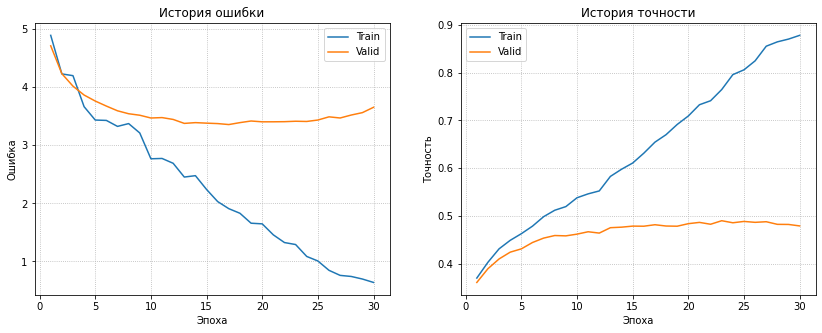

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.6335
Точность на тесте: 0.4822
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.60      0.53      0.56      1000
           1       0.61      0.59      0.60      1000
           2       0.35      0.39      0.36      1000
           3       0.35      0.27      0.30      1000
           4       0.35      0.55      0.43      1000
           5       0.38      0.43      0.40      1000
           6       0.53      0.47      0.50      1000
           7       0.63      0.43      0.51      1000
           8       0.57      0.71      0.63      1000
           9       0.61      0.46      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.50      0.48      0.48     10000


In [22]:
model = Sequential(
    Linear(3072, 768*2),
    Sigmoid(),
    Linear(768*2, 128),
    Sigmoid(),
    Linear(128, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, optimizer="Adam", batch_size=3000)
start_train.run()

Sequential(
	Linear(3072, 2304, bias=True),
	Sigmoid(),
	Linear(2304, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  4.6116  | 0.3542  |  4.7327  | 0.3492  | 0.009354 |   18.6   |   18.6   |
| 2/30|  4.0135  | 0.4008  |  4.2001  | 0.3897  | 0.007787 |   18.2   |   36.8   |
| 3/30|  4.1300  | 0.4319  |  3.9639  | 0.4168  | 0.008265 |   24.4   |   61.2   |
| 4/30|  3.6705  | 0.4508  |  3.7885  | 0.4280  | 0.006981 |   30.5   |   91.7   |
| 5/30|  3.6400  | 0.4697  |  3.6799  | 0.4441  | 0.005776 |   27.8   |  119.5   |
| 6/30|  3.6213  | 0.4818  |  3.6182  | 0.4483  | 0.004682 |   23.5   |  143.0   |
| 7/30|  3.1943  | 0.4998  |  3.5284  | 0.4553  | 0.004833 |   22.9   |  165.8   |
| 8/30|  2.9163  | 0.5138  |  3.4708  | 0.4594  | 0.003088 |   28.5   |  194.3   |
| 9/30|  2.7277  | 0.5297  |  3.4359  | 0.4

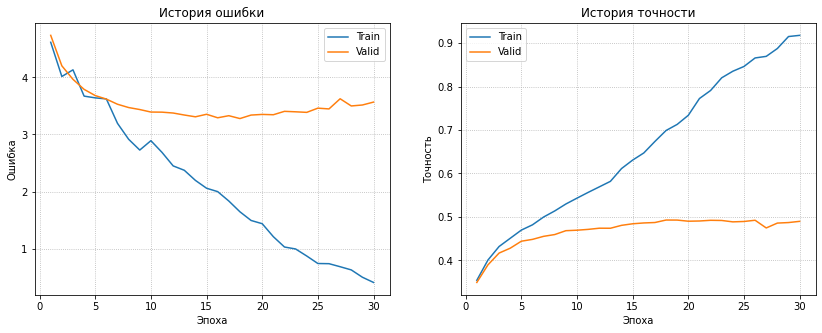

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.5693
Точность на тесте: 0.4894
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.51      0.63      0.57      1000
           1       0.69      0.49      0.57      1000
           2       0.40      0.33      0.36      1000
           3       0.33      0.35      0.34      1000
           4       0.47      0.38      0.42      1000
           5       0.40      0.40      0.40      1000
           6       0.55      0.55      0.55      1000
           7       0.50      0.57      0.53      1000
           8       0.55      0.66      0.60      1000
           9       0.54      0.54      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000


In [27]:
model = Sequential(
    Linear(3072, 768*3),
    Sigmoid(),
    Linear(768*3, 128),
    Sigmoid(),
    Linear(128, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, optimizer="Adam", batch_size=3000)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 256, bias=True),
	Sigmoid(),
	Linear(256, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  4.6247  | 0.3618  |  4.7744  | 0.3592  | 0.014580 |   8.0    |   8.0    |
| 2/30|  4.3432  | 0.3940  |  4.3116  | 0.3851  | 0.005031 |   7.8    |   15.8   |
| 3/30|  4.1878  | 0.4255  |  4.1009  | 0.4073  | 0.007782 |   7.5    |   23.3   |
| 4/30|  3.6128  | 0.4361  |  3.9725  | 0.4116  | 0.005473 |   8.3    |   31.7   |
| 5/30|  3.8815  | 0.4568  |  3.8449  | 0.4325  | 0.007818 |   8.1    |   39.8   |
| 6/30|  3.4216  | 0.4718  |  3.7480  | 0.4390  | 0.003922 |   8.1    |   47.9   |
| 7/30|  3.3716  | 0.4826  |  3.6800  | 0.4479  | 0.004246 |   8.3    |   56.2   |
| 8/30|  3.2009  | 0.4989  |  3.6118  | 0.4547  | 0.005008 |   9.5    |   65.7   |
| 9/30|  2.7975  | 0.5079  |  3.5899  | 0.4

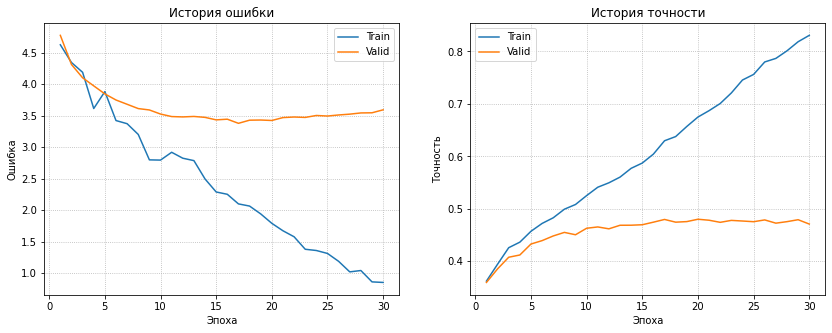

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.6496
Точность на тесте: 0.4678
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.61      0.50      0.55      1000
           1       0.60      0.49      0.54      1000
           2       0.36      0.35      0.36      1000
           3       0.31      0.33      0.32      1000
           4       0.35      0.38      0.37      1000
           5       0.38      0.37      0.37      1000
           6       0.48      0.56      0.52      1000
           7       0.55      0.50      0.52      1000
           8       0.58      0.66      0.62      1000
           9       0.51      0.54      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000


In [26]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128*2),
    Sigmoid(),
    Linear(128*2, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, optimizer="Adam", batch_size=3000)
start_train.run()

Sequential(
	Linear(3072, 384, bias=True),
	Sigmoid(),
	Linear(384, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  5.1892  | 0.3421  |  4.9327  | 0.3377  | 0.004882 |   4.5    |   4.5    |                   ] 8/14 1s>1s
| 2/30|  4.2276  | 0.3856  |  4.4732  | 0.3777  | 0.003135 |   4.9    |   9.4    |
| 3/30|  4.1136  | 0.4078  |  4.2469  | 0.3922  | 0.001889 |   4.3    |   13.6   |
| 4/30|  3.8764  | 0.4230  |  4.1036  | 0.4002  | 0.001540 |   4.2    |   17.8   |
| 5/30|  3.7832  | 0.4371  |  4.0105  | 0.4159  | 0.003163 |   4.3    |   22.1   |
| 6/30|  3.5439  | 0.4451  |  3.9361  | 0.4191  | 0.002708 |   4.4    |   26.5   |
| 7/30|  3.5919  | 0.4570  |  3.8700  | 0.4275  | 0.001876 |   4.3    |   30.8   |
| 8/30|  3.5185  | 0.4614  |  3.8364  | 0.4281  | 0.001677 |   4.7    |   35.4   |
| 9/30|  3.3

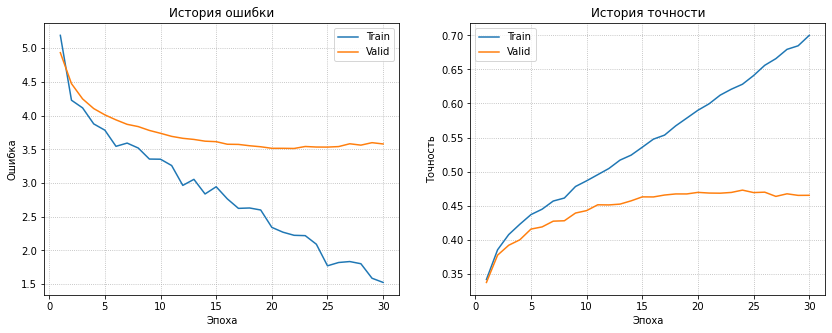

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.5848
Точность на тесте: 0.4698
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.56      0.53      0.55      1000
           1       0.59      0.54      0.56      1000
           2       0.38      0.36      0.37      1000
           3       0.32      0.33      0.33      1000
           4       0.39      0.35      0.37      1000
           5       0.38      0.37      0.37      1000
           6       0.49      0.54      0.52      1000
           7       0.50      0.51      0.50      1000
           8       0.56      0.65      0.60      1000
           9       0.52      0.52      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000


In [25]:
model = Sequential(
    Linear(3072, int(768/2)),
    Sigmoid(),
    Linear(int(768/2), 128),
    Sigmoid(),
    Linear(128, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, optimizer="Adam", batch_size=3000)
start_train.run()

Видим, что при увеличении количества нейронов точность модели тоже увеличивается. Это связано с тем, что обобщательная способность с числом нейронов растёт, но при этом мы получили переобучение

### Эксперимент 9 Эксперимент c размером батча

Зафиксируйте модель и обучитесь на разных размерах. Как размер батча влияет на процесс обучения?

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  3.0541  | 0.4084  |  4.0221  | 0.3918  | 0.014740 |   48.9   |   48.9   |  >                               ] 145/400 14s>26s
| 2/30|  3.7710  | 0.4688  |  3.6576  | 0.4341  | 0.014033 |   49.6   |   98.5   |  195/400 23s>24s
| 3/30|  3.4654  | 0.4949  |  3.4780  | 0.4527  | 0.012828 |   52.7   |  151.2   |  
| 4/30|  3.5844  | 0.5194  |  3.3895  | 0.4633  | 0.010596 |   45.1   |  196.3   |  
| 5/30|  3.3944  | 0.5329  |  3.3666  | 0.4628  | 0.005489 |   50.7   |  247.0   |  10s>37s                           ] 179/400 20s>25s
| 6/30|  3.2976  | 0.5469  |  3.3309  | 0.4708  | 0.005404 |   46.7   |  293.6   |  
| 7/30|  2.4416  | 0.5671  |  3.3310  | 0.4696  | 0.005446 |   45.8   |  339.4   |

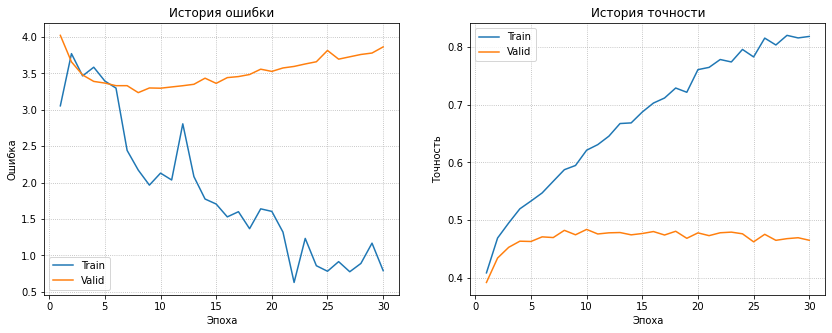

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.8717
Точность на тесте: 0.4741
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.52      0.59      0.56      1000
           1       0.59      0.56      0.57      1000
           2       0.45      0.27      0.33      1000
           3       0.31      0.39      0.35      1000
           4       0.37      0.46      0.41      1000
           5       0.36      0.34      0.35      1000
           6       0.46      0.59      0.52      1000
           7       0.61      0.46      0.52      1000
           8       0.67      0.55      0.60      1000
           9       0.50      0.55      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.49      0.47      0.47     10000


In [29]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, batch_size=100)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  4.4652  | 0.4222  |  4.0975  | 0.4080  | 0.005999 |   11.6   |   11.6   |
| 2/30|  3.4219  | 0.4541  |  3.7671  | 0.4306  | 0.005817 |   12.0   |   23.6   |
| 3/30|  3.5058  | 0.4865  |  3.5701  | 0.4506  | 0.005406 |   12.1   |   35.7   |
| 4/30|  3.1438  | 0.5140  |  3.4987  | 0.4555  | 0.005442 |   12.5   |   48.2   |
| 5/30|  3.0094  | 0.5336  |  3.4073  | 0.4647  | 0.003667 |   12.7   |   61.0   |
| 6/30|  2.8815  | 0.5553  |  3.3883  | 0.4662  | 0.004140 |   13.0   |   74.0   |
| 7/30|  2.5177  | 0.5881  |  3.3206  | 0.4779  | 0.002745 |   13.4   |   87.4   |
| 8/30|  2.5135  | 0.6081  |  3.3187  | 0.4772  | 0.003438 |   13.6   |  101.0   |
| 9/30|  2.1881  | 0.6300  |  3.3131  | 0.4

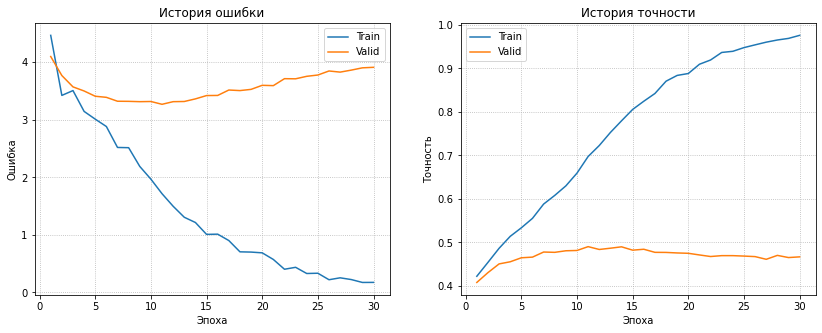

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.9815
Точность на тесте: 0.4624
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.51      0.56      0.53      1000
           1       0.59      0.53      0.56      1000
           2       0.35      0.35      0.36      1000
           3       0.31      0.24      0.27      1000
           4       0.40      0.38      0.39      1000
           5       0.35      0.38      0.37      1000
           6       0.49      0.56      0.52      1000
           7       0.50      0.51      0.50      1000
           8       0.56      0.64      0.60      1000
           9       0.52      0.47      0.49      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000


In [30]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, batch_size=500)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  4.2731  | 0.3950  |  4.3374  | 0.3831  | 0.009423 |   9.1    |   9.1    |
| 2/30|  3.9142  | 0.4394  |  3.9442  | 0.4191  | 0.009139 |   8.8    |   17.9   |
| 3/30|  3.6558  | 0.4628  |  3.7678  | 0.4369  | 0.005678 |   8.9    |   26.8   |
| 4/30|  3.2005  | 0.4855  |  3.6640  | 0.4445  | 0.003577 |   9.1    |   36.0   |
| 5/30|  3.1572  | 0.5037  |  3.5842  | 0.4493  | 0.004933 |   9.4    |   45.4   |
| 6/30|  2.8443  | 0.5262  |  3.5044  | 0.4602  | 0.003916 |   9.5    |   54.9   |
| 7/30|  2.9311  | 0.5508  |  3.4495  | 0.4691  | 0.002460 |   9.8    |   64.7   |
| 8/30|  2.7997  | 0.5717  |  3.4190  | 0.4714  | 0.002221 |   10.0   |   74.7   |
| 9/30|  2.4184  | 0.5851  |  3.3863  | 0.4

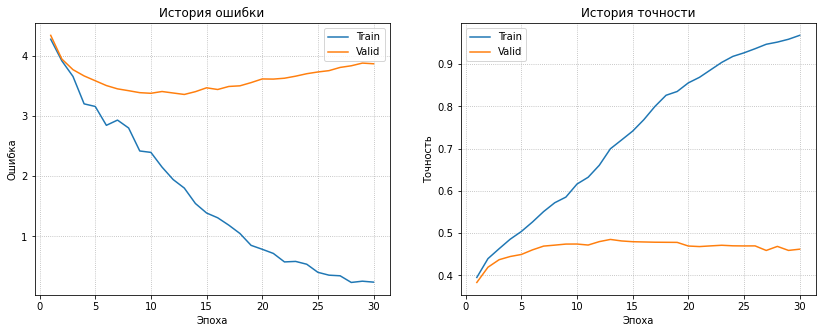

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.9314
Точность на тесте: 0.4561
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.53      0.57      0.55      1000
           1       0.53      0.53      0.53      1000
           2       0.34      0.36      0.35      1000
           3       0.31      0.30      0.31      1000
           4       0.40      0.39      0.39      1000
           5       0.34      0.40      0.37      1000
           6       0.49      0.49      0.49      1000
           7       0.51      0.44      0.47      1000
           8       0.61      0.59      0.60      1000
           9       0.52      0.49      0.51      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000


In [31]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, batch_size=1000)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  5.6565  | 0.3109  |  5.3564  | 0.3073  | 0.010969 |   6.8    |   6.8    |
| 2/30|  4.9028  | 0.3503  |  4.7651  | 0.3480  | 0.008208 |   6.9    |   13.8   |
| 3/30|  4.4989  | 0.3831  |  4.4422  | 0.3771  | 0.002983 |   6.9    |   20.7   |
| 4/30|  4.1415  | 0.4035  |  4.2500  | 0.3922  | 0.004018 |   7.0    |   27.6   |
| 5/30|  3.9809  | 0.4183  |  4.1148  | 0.4021  | 0.003360 |   7.4    |   35.0   |
| 6/30|  3.9657  | 0.4317  |  4.0217  | 0.4162  | 0.002220 |   9.2    |   44.2   |
| 7/30|  3.8492  | 0.4433  |  3.9492  | 0.4224  | 0.002451 |   10.8   |   55.0   |
| 8/30|  3.6756  | 0.4506  |  3.8819  | 0.4293  | 0.002538 |   13.3   |   68.3   |
| 9/30|  3.6147  | 0.4585  |  3.8373  | 0.4

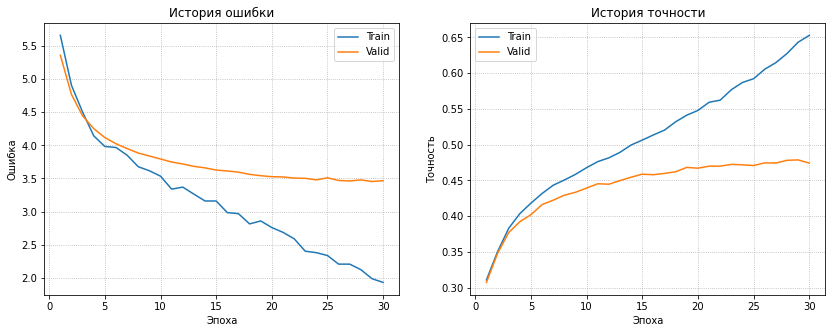

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4884
Точность на тесте: 0.4800
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.52      0.62      0.56      1000
           1       0.59      0.55      0.57      1000
           2       0.38      0.33      0.35      1000
           3       0.33      0.35      0.34      1000
           4       0.40      0.37      0.39      1000
           5       0.41      0.36      0.39      1000
           6       0.46      0.59      0.52      1000
           7       0.51      0.51      0.51      1000
           8       0.63      0.60      0.62      1000
           9       0.56      0.51      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000


In [32]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, batch_size=5000)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  5.8673  | 0.2842  |  5.7901  | 0.2806  | 0.008811 |   9.2    |   9.2    |
| 2/30|  5.2887  | 0.3384  |  5.2087  | 0.3313  | 0.009901 |   8.8    |   18.1   |
| 3/30|  4.9052  | 0.3489  |  4.8861  | 0.3411  | 0.007834 |   9.1    |   27.2   |
| 4/30|  4.7425  | 0.3687  |  4.6888  | 0.3589  | 0.008209 |   8.9    |   36.0   |
| 5/30|  4.4884  | 0.3793  |  4.5185  | 0.3680  | 0.002113 |   9.4    |   45.5   |
| 6/30|  4.3257  | 0.3901  |  4.4073  | 0.3745  | 0.002490 |   9.7    |   55.2   |
| 7/30|  4.2539  | 0.3982  |  4.3058  | 0.3847  | 0.002844 |   10.1   |   65.3   |
| 8/30|  4.0890  | 0.4064  |  4.2262  | 0.3909  | 0.002014 |   11.4   |   76.7   |
| 9/30|  4.0696  | 0.4151  |  4.1589  | 0.3

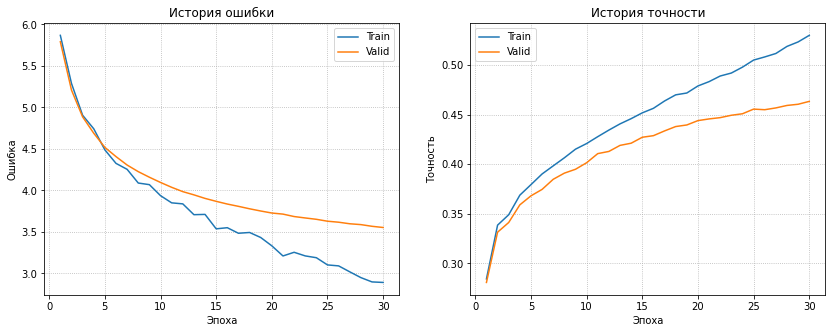

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.5485
Точность на тесте: 0.4625
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.55      0.53      0.54      1000
           1       0.56      0.50      0.53      1000
           2       0.35      0.30      0.32      1000
           3       0.32      0.38      0.35      1000
           4       0.42      0.37      0.39      1000
           5       0.39      0.36      0.38      1000
           6       0.46      0.55      0.50      1000
           7       0.52      0.49      0.51      1000
           8       0.55      0.63      0.59      1000
           9       0.50      0.51      0.50      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000


In [33]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, batch_size=10000)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  6.3117  | 0.2631  |  5.9270  | 0.2625  | 0.010184 |   7.8    |   7.9    |
| 2/30|  5.5305  | 0.3041  |  5.5201  | 0.2932  | 0.008088 |   7.2    |   15.1   |
| 3/30|  5.2571  | 0.3353  |  5.1895  | 0.3285  | 0.007523 |   7.9    |   22.9   |
| 4/30|  4.8867  | 0.3503  |  4.8981  | 0.3437  | 0.004416 |   7.9    |   30.8   |
| 5/30|  4.6228  | 0.3511  |  4.7598  | 0.3439  | 0.002324 |   7.4    |   38.3   |
| 6/30|  4.6884  | 0.3615  |  4.6388  | 0.3527  | 0.002601 |   8.0    |   46.2   |
| 7/30|  4.4563  | 0.3775  |  4.5181  | 0.3690  | 0.001438 |   9.1    |   55.4   |
| 8/30|  4.3787  | 0.3864  |  4.4235  | 0.3778  | 0.001227 |   11.4   |   66.8   |
| 9/30|  4.2944  | 0.3920  |  4.3463  | 0.3

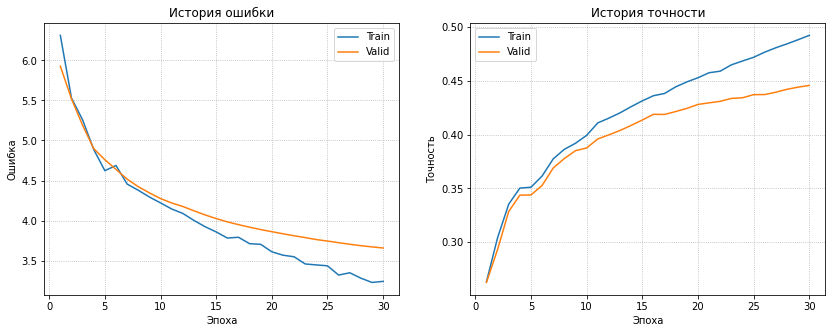

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.6508
Точность на тесте: 0.4523
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      1000
           1       0.54      0.51      0.52      1000
           2       0.36      0.28      0.31      1000
           3       0.33      0.32      0.33      1000
           4       0.40      0.35      0.37      1000
           5       0.37      0.37      0.37      1000
           6       0.44      0.57      0.49      1000
           7       0.50      0.49      0.49      1000
           8       0.54      0.60      0.57      1000
           9       0.48      0.53      0.50      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000


In [34]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, batch_size=15000)
start_train.run()

Заметим, что до определённого момента точность возрастает с увеличением размера батча,а ошибка более круто падает,при достаточно низком размере батча получаем переобучение

### Эксперимент 10 Эксперимент с регуляризацией

Добавьте в процесс обучения L1/L2 регуляризацию. Повлияло ли это на качесвто? Выведите норму весов без регуляризации и с. 

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  4.7292  | 0.3619  |  4.7271  | 0.3568  | 0.009983 |   9.3    |   9.3    |
| 2/15|  4.1696  | 0.4003  |  4.3026  | 0.3875  | 0.008217 |   8.8    |   18.2   |
| 3/15|  4.0307  | 0.4215  |  4.0938  | 0.4073  | 0.006185 |   8.4    |   26.5   |
| 4/15|  3.7326  | 0.4383  |  3.9570  | 0.4163  | 0.006711 |   8.7    |   35.2   |
| 5/15|  3.8795  | 0.4585  |  3.8225  | 0.4345  | 0.004532 |   8.5    |   43.7   |
| 6/15|  3.3485  | 0.4666  |  3.7388  | 0.4371  | 0.003370 |   8.3    |   52.0   |
| 7/15|  3.5987  | 0.4835  |  3.6806  | 0.4473  | 0.004280 |   8.7    |   60.7   |
| 8/15|  3.5083  | 0.4968  |  3.6263  | 0.4548  | 0.005669 |   9.0    |   69.6   |
| 9/15|  3.0947  | 0.5066  |  3.5763  | 0.4

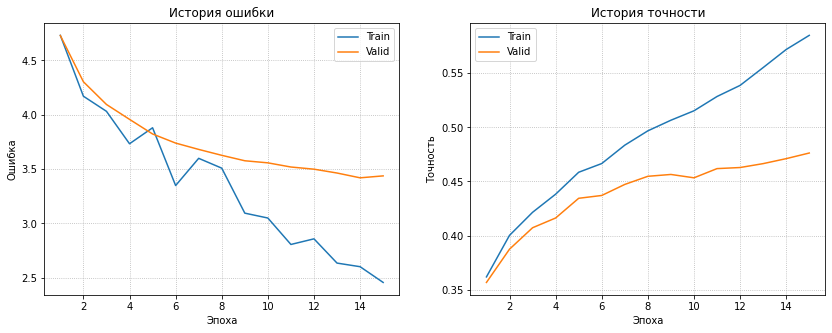

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4379
Точность на тесте: 0.4752
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.52      0.58      0.55      1000
           1       0.60      0.57      0.58      1000
           2       0.36      0.34      0.35      1000
           3       0.31      0.34      0.33      1000
           4       0.44      0.35      0.39      1000
           5       0.37      0.39      0.38      1000
           6       0.49      0.56      0.52      1000
           7       0.51      0.52      0.52      1000
           8       0.61      0.62      0.61      1000
           9       0.56      0.49      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000


In [35]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, alpha1=0, alpha2=0)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.3269  | 0.3359  |  5.1291  | 0.3246  | 0.015043 |   8.8    |   8.8    |
| 2/15|  5.0178  | 0.3538  |  4.9548  | 0.3533  | 0.008428 |   8.4    |   17.2   |
| 3/15|  4.8469  | 0.3577  |  4.9452  | 0.3510  | 0.004176 |   8.1    |   25.3   |
| 4/15|  4.9334  | 0.3470  |  5.0260  | 0.3451  | 0.006305 |   8.3    |   33.5   |
| 5/15|  5.0959  | 0.3226  |  5.0895  | 0.3230  | 0.007596 |   8.1    |   41.6   |
| 6/15|  5.0092  | 0.3470  |  4.9764  | 0.3431  | 0.010071 |   8.8    |   50.5   |
| 7/15|  5.2280  | 0.3530  |  4.9485  | 0.3510  | 0.011764 |   8.4    |   58.8   |
| 8/15|  5.0320  | 0.3497  |  4.9152  | 0.3463  | 0.012254 |   8.7    |   67.5   |
| 9/15|  4.9005  | 0.3488  |  4.8910  | 0.3

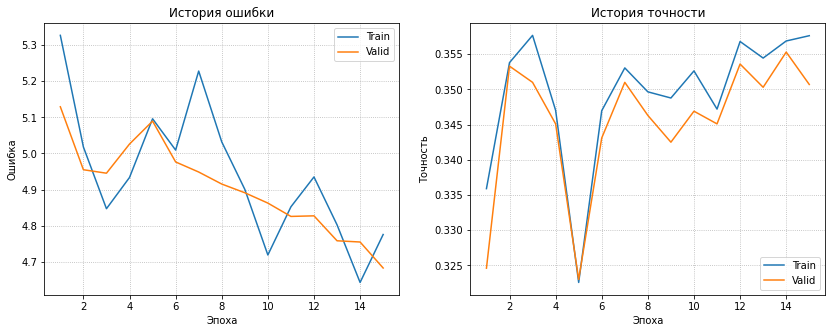

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 4.6772
Точность на тесте: 0.3598
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.39      0.42      0.40      1000
           1       0.49      0.28      0.36      1000
           2       0.25      0.08      0.12      1000
           3       0.24      0.18      0.20      1000
           4       0.30      0.31      0.31      1000
           5       0.35      0.32      0.33      1000
           6       0.30      0.65      0.41      1000
           7       0.43      0.35      0.39      1000
           8       0.41      0.53      0.46      1000
           9       0.44      0.48      0.46      1000

    accuracy                           0.36     10000
   macro avg       0.36      0.36      0.34     10000


In [36]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, alpha1=0.001, alpha2=0.01)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  4.9082  | 0.3567  |  5.0180  | 0.3436  | 0.008055 |   10.3   |   10.3   |
| 2/15|  4.5613  | 0.3685  |  4.8308  | 0.3560  | 0.004781 |   8.8    |   19.1   |
| 3/15|  4.8014  | 0.3638  |  4.8292  | 0.3555  | 0.010848 |   10.7   |   29.8   |
| 4/15|  4.9859  | 0.3526  |  4.8664  | 0.3491  | 0.009973 |   9.6    |   39.3   |
| 5/15|  4.8681  | 0.3604  |  4.8599  | 0.3510  | 0.011543 |   9.5    |   48.8   |
| 6/15|  4.8874  | 0.3480  |  4.9676  | 0.3416  | 0.005175 |   9.4    |   58.1   |
| 7/15|  4.6481  | 0.3521  |  4.8412  | 0.3522  | 0.011421 |   9.5    |   67.6   |
| 8/15|  4.5093  | 0.3468  |  4.9021  | 0.3458  | 0.014641 |   9.8    |   77.4   |
| 9/15|  4.6364  | 0.3607  |  4.8012  | 0.3

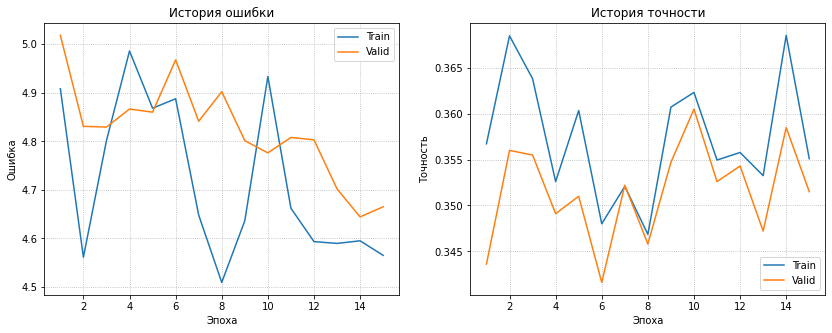

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 4.6398
Точность на тесте: 0.3575
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.42      0.32      0.36      1000
           1       0.53      0.27      0.35      1000
           2       0.20      0.14      0.16      1000
           3       0.24      0.19      0.21      1000
           4       0.29      0.44      0.35      1000
           5       0.37      0.32      0.34      1000
           6       0.35      0.51      0.41      1000
           7       0.48      0.26      0.34      1000
           8       0.40      0.60      0.48      1000
           9       0.38      0.54      0.45      1000

    accuracy                           0.36     10000
   macro avg       0.37      0.36      0.35     10000


In [37]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, alpha1=0.001, alpha2=0.001)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  7.0195  | 0.2480  |  6.9907  | 0.2441  | 0.003643 |   7.7    |   7.7    |
| 2/15|  6.6693  | 0.2751  |  6.6686  | 0.2678  | 0.005653 |   10.6   |   18.3   |
| 3/15|  6.6471  | 0.2636  |  6.8078  | 0.2570  | 0.009401 |   8.3    |   26.6   |
| 4/15|  7.1030  | 0.2291  |  7.0522  | 0.2255  | 0.006694 |   7.7    |   34.3   |
| 5/15|  7.1620  | 0.1885  |  7.0876  | 0.1887  | 0.006576 |   10.1   |   44.5   |
| 6/15|  6.7689  | 0.2014  |  6.9267  | 0.1965  | 0.008725 |   15.2   |   59.7   |
| 7/15|  6.9467  | 0.1793  |  6.8001  | 0.1791  | 0.009665 |   18.4   |   78.1   |
| 8/15|  6.7471  | 0.2078  |  6.7353  | 0.2018  | 0.007250 |   18.2   |   96.2   |
| 9/15|  6.6986  | 0.1765  |  6.6900  | 0.1

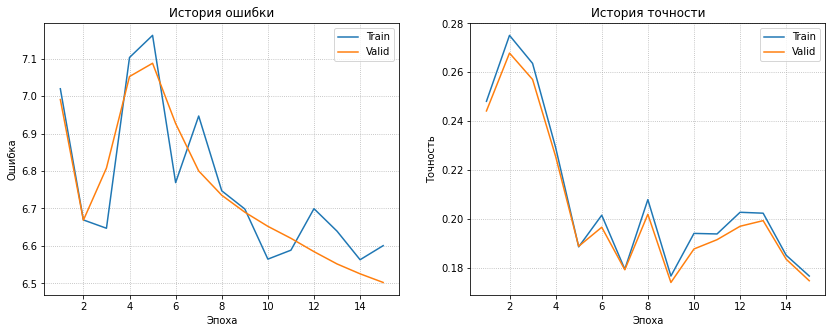

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 6.4849
Точность на тесте: 0.1765
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.18      0.79      0.29      1000
           1       0.48      0.02      0.04      1000
           2       0.11      0.08      0.09      1000
           3       0.25      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.19      0.10      0.13      1000
           6       0.18      0.78      0.29      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.18     10000
   macro avg       0.14      0.18      0.09     10000


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, alpha1=0.01, alpha2=0.001)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  7.4559  | 0.2432  |  7.3290  | 0.2447  | 0.005254 |   8.4    |   8.4    |
| 2/15|  6.9688  | 0.2285  |  6.8816  | 0.2268  | 0.006552 |   9.9    |   18.3   |
| 3/15|  7.0632  | 0.2695  |  6.9720  | 0.2693  | 0.007603 |   9.1    |   27.3   |
| 4/15|  7.1591  | 0.2531  |  7.2144  | 0.2507  | 0.007125 |   10.7   |   38.0   |
| 5/15|  7.1211  | 0.2249  |  7.2714  | 0.2194  | 0.008240 |   12.9   |   50.9   |
| 6/15|  7.1571  | 0.1733  |  7.1207  | 0.1722  | 0.008654 |   15.7   |   66.6   |
| 7/15|  7.1158  | 0.1950  |  6.9731  | 0.1951  | 0.008939 |   20.4   |   87.1   |
| 8/15|  6.9097  | 0.1852  |  6.8435  | 0.1856  | 0.008821 |   18.5   |  105.6   |
| 9/15|  6.7207  | 0.1748  |  6.7729  | 0.1

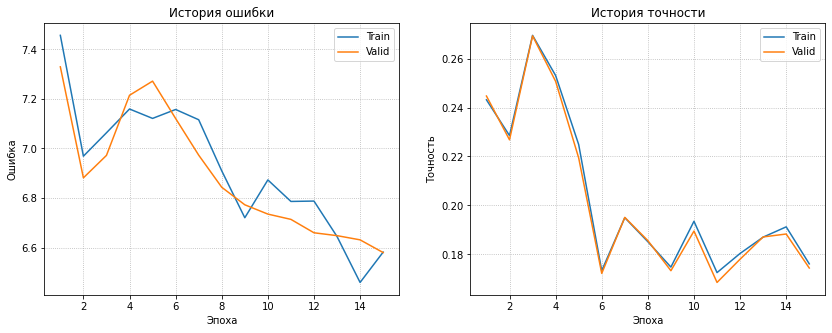

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 6.5587
Точность на тесте: 0.1811
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.16      0.14      0.15      1000
           2       0.00      0.00      0.00      1000
           3       0.13      0.06      0.08      1000
           4       0.00      0.00      0.00      1000
           5       0.16      0.21      0.18      1000
           6       0.19      0.68      0.30      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.19      0.71      0.30      1000

    accuracy                           0.18     10000
   macro avg       0.08      0.18      0.10     10000


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, alpha1=0.01, alpha2=0.01)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  8.9997  | 0.1046  |  8.8372  | 0.1056  | 0.011446 |   9.4    |   9.5    |
| 2/15|  8.8379  | 0.1031  |  8.8190  | 0.1043  | 0.017625 |   11.3   |   20.8   |
| 3/15|  8.9572  | 0.1036  |  8.9215  | 0.1044  | 0.023534 |   11.6   |   32.4   |
| 4/15|  9.0152  | 0.1000  |  8.9868  | 0.1000  | 0.178359 |   12.1   |   44.5   |
| 5/15|  9.1130  | 0.1000  |  8.9966  | 0.1000  | 0.045926 |   13.6   |   58.2   |
| 6/15|  9.0637  | 0.1000  |  8.9994  | 0.1000  | 0.071208 |   14.3   |   72.4   |
| 7/15|  9.0868  | 0.1000  |  9.0002  | 0.1000  | 0.029639 |   14.6   |   87.1   |
| 8/15|  8.9617  | 0.1000  |  9.0002  | 0.1000  | 0.077811 |   13.2   |  100.3   |
| 9/15|  9.0280  | 0.1000  |  9.0000  | 0.1

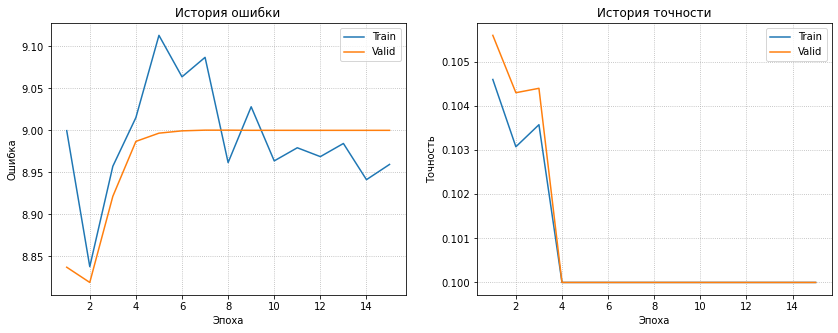

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 9.0000
Точность на тесте: 0.1000
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.10      1.00      0.18      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, alpha1=0.1, alpha2=0.1)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  9.2263  | 0.1000  |  9.2477  | 0.1000  | 0.122795 |   8.7    |   8.7    |
| 2/15|  9.0858  | 0.1000  |  9.1178  | 0.1000  | 0.106683 |   8.9    |   17.6   |
| 3/15|  9.2882  | 0.1000  |  9.0601  | 0.1000  | 0.130920 |   8.6    |   26.1   |
| 4/15|  8.9751  | 0.1000  |  9.0406  | 0.1000  | 0.122354 |   9.5    |   35.6   |
| 5/15|  9.1642  | 0.1000  |  9.0239  | 0.1000  | 0.155195 |   9.4    |   45.0   |
| 6/15|  8.7363  | 0.1000  |  9.0148  | 0.1000  | 0.088718 |   10.9   |   55.9   |
| 7/15|  8.9801  | 0.1000  |  9.0046  | 0.1000  | 0.176054 |   10.0   |   65.9   |
| 8/15|  9.0182  | 0.1000  |  9.0000  | 0.1000  | 0.144623 |   9.5    |   75.4   |
| 9/15|  9.1251  | 0.1000  |  9.0000  | 0.1

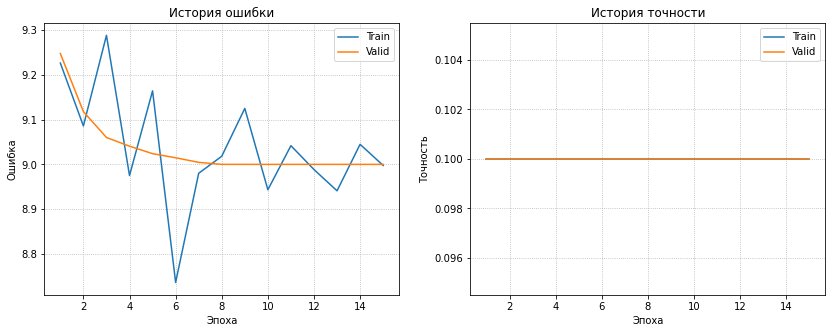

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 9.0000
Точность на тесте: 0.1000
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.10      1.00      0.18      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, alpha1=1, alpha2=1)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  8.6916  | 0.0990  |  8.9957  | 0.0989  | 0.092988 |   10.3   |   10.3   |
| 2/15|  8.9548  | 0.1010  |  8.9833  | 0.1007  | 0.077409 |   8.9    |   19.3   |
| 3/15|  9.1155  | 0.0976  |  8.9903  | 0.0969  | 0.086418 |   10.5   |   29.8   |
| 4/15|  8.9525  | 0.1026  |  9.0042  | 0.1019  | 0.145269 |   11.8   |   41.6   |
| 5/15|  9.0394  | 0.1000  |  8.9980  | 0.1000  | 0.226098 |   13.8   |   55.4   |
| 6/15|  9.0349  | 0.1000  |  9.0004  | 0.1000  | 0.053097 |   16.0   |   71.4   |
| 7/15|  9.0990  | 0.1000  |  8.9994  | 0.1000  | 0.125573 |   14.3   |   85.7   |
| 8/15|  9.0442  | 0.1000  |  9.0000  | 0.1000  | 0.172184 |   13.0   |   98.7   |
| 9/15|  8.9500  | 0.1000  |  9.0000  | 0.1

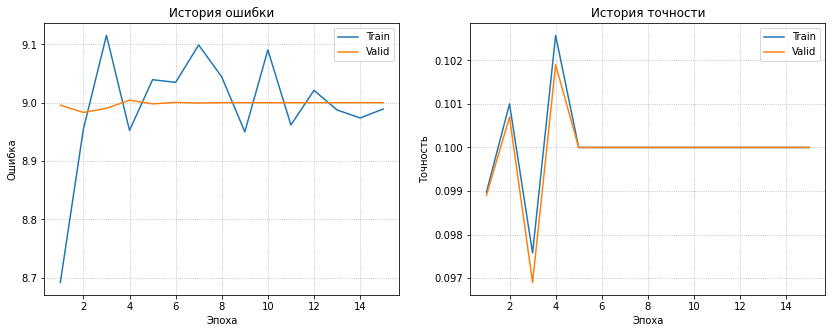

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 9.0000
Точность на тесте: 0.1000
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.10      1.00      0.18      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, alpha1=1, alpha2=0)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  6.8002  | 0.2639  |  6.7393  | 0.2601  | 0.003090 |   9.4    |   9.5    |
| 2/15|  6.4179  | 0.2772  |  6.5203  | 0.2754  | 0.001638 |   9.1    |   18.6   |
| 3/15|  6.5894  | 0.2846  |  6.5641  | 0.2783  | 0.002199 |   8.9    |   27.5   |
| 4/15|  6.7127  | 0.2690  |  6.6967  | 0.2649  | 0.002658 |   10.8   |   38.3   |
| 5/15|  6.8763  | 0.2326  |  6.8208  | 0.2292  | 0.003124 |   12.3   |   50.6   |
| 6/15|  6.8220  | 0.2347  |  6.9026  | 0.2343  | 0.002712 |   13.6   |   64.2   |
| 7/15|  7.0538  | 0.2340  |  6.9843  | 0.2319  | 0.001622 |   13.9   |   78.1   |
| 8/15|  7.0584  | 0.2112  |  7.0437  | 0.2089  | 0.002642 |   12.9   |   91.0   |
| 9/15|  7.2172  | 0.2067  |  7.0972  | 0.2

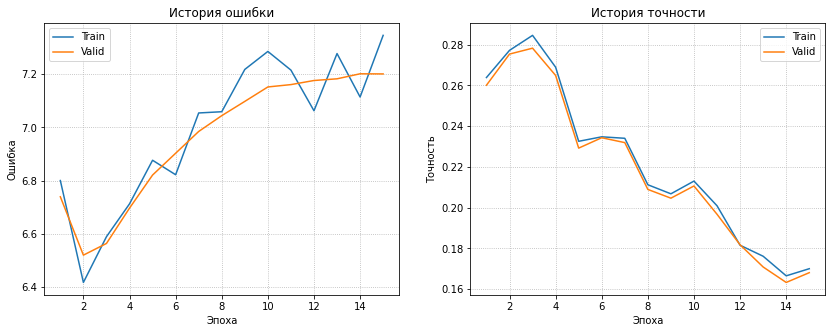

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 7.2032
Точность на тесте: 0.1720
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.19      0.79      0.31      1000
           1       0.11      0.00      0.00      1000
           2       0.12      0.17      0.14      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.15      0.12      0.14      1000
           6       0.18      0.64      0.28      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.17     10000
   macro avg       0.07      0.17      0.09     10000


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, alpha1=0, alpha2=1)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  4.8071  | 0.3504  |  4.8003  | 0.3476  | 0.007901 |   8.9    |   9.0    |
| 2/15|  4.5441  | 0.3942  |  4.3054  | 0.3875  | 0.002295 |   8.9    |   17.9   |
| 3/15|  3.9581  | 0.4192  |  4.1226  | 0.4073  | 0.003133 |   9.6    |   27.4   |
| 4/15|  3.5370  | 0.4293  |  3.9947  | 0.4155  | 0.003684 |   10.2   |   37.6   |
| 5/15|  3.5391  | 0.4444  |  3.9228  | 0.4285  | 0.004326 |   10.6   |   48.2   |
| 6/15|  3.4459  | 0.4495  |  3.8658  | 0.4279  | 0.003688 |   10.3   |   58.4   |
| 7/15|  3.7317  | 0.4456  |  3.8835  | 0.4232  | 0.004766 |   10.7   |   69.2   |
| 8/15|  3.5201  | 0.4528  |  3.8363  | 0.4301  | 0.004915 |   10.6   |   79.8   |
| 9/15|  3.7232  | 0.4543  |  3.8077  | 0.4

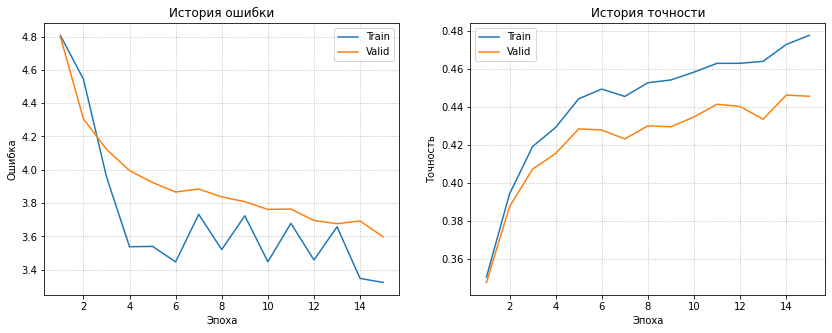

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.6255
Точность на тесте: 0.4496
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      1000
           1       0.59      0.48      0.53      1000
           2       0.33      0.32      0.33      1000
           3       0.32      0.34      0.33      1000
           4       0.40      0.30      0.34      1000
           5       0.40      0.31      0.35      1000
           6       0.42      0.59      0.49      1000
           7       0.48      0.50      0.49      1000
           8       0.59      0.59      0.59      1000
           9       0.47      0.52      0.50      1000

    accuracy                           0.45     10000
   macro avg       0.45      0.45      0.45     10000


In [44]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, alpha1=0.0001, alpha2=0.0001)
start_train.run()

Sequential(
	Linear(3072, 2500, bias=True),
	Sigmoid(),
	Linear(2500, 1500, bias=True),
	Sigmoid(),
	Linear(1500, 512, bias=True),
	Sigmoid(),
	Linear(512, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
| Epoch |Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=======|==========|=========|==========|=========|==========|==========|==========|
|  1/100|  5.7055  | 0.2651  |  5.6145  | 0.2595  | 0.003403 |   35.5   |   35.5   |
|  2/100|  5.1372  | 0.3315  |  4.9643  | 0.3254  | 0.004038 |   32.8   |   68.3   |
|  3/100|  4.5696  | 0.3640  |  4.5246  | 0.3596  | 0.001783 |   34.3   |  102.7   |
|  4/100|  4.2413  | 0.3896  |  4.2969  | 0.3760  | 0.002001 |   34.2   |  136.9   |
|  5/100|  3.6749  | 0.4160  |  4.0285  | 0.4006  | 0.000841 |   33.9   |  170.8   |
|  6/100|  3.6034  | 0.4403  |  3.8600  | 0.4141  | 0.001868 |   34.3   |  205.1   |
|  7/100|  3.3274  | 0.4637  |  3.7199  | 0.4255  | 0.001029 |   41.7   |  246.8   |
|  8/100|  2.9106  | 0.4829  |  3.5391  | 0.4419  | 0.001538 |   35.8   |  282.6   |
|  9/100|  2.9236  | 0.

/Users/admin/Downloads/Numpy-NN-Framework-hw-main/src/utils.py:124: RuntimeWarning: invalid value encountered in double_scalars
  diff = LA.norm(norm_chicl-norm_backprop) / (LA.norm(norm_chicl)+LA.norm(norm_backprop))


norm_chicl norm =  0.0
norm_backprop norm =  0.0
diff =  nan
Backprop is incorrect!
Drawing training curves...
____________________________________________________________________________________________________


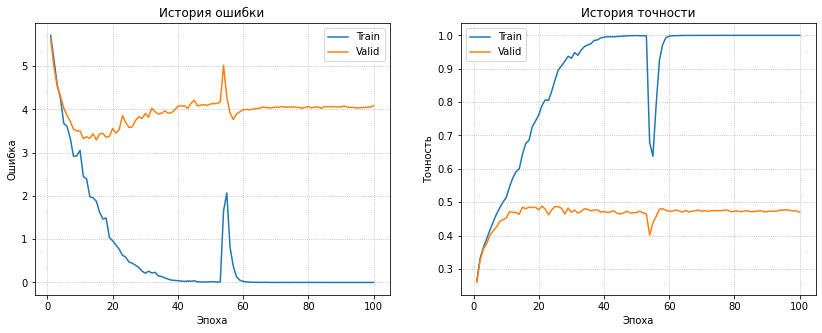

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 4.0868
Точность на тесте: 0.4759
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      1000
           1       0.63      0.57      0.60      1000
           2       0.38      0.37      0.38      1000
           3       0.29      0.37      0.33      1000
           4       0.36      0.43      0.39      1000
           5       0.41      0.43      0.42      1000
           6       0.59      0.46      0.51      1000
           7       0.56      0.46      0.50      1000
           8       0.57      0.65      0.61      1000
           9       0.56      0.48      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.48     10000


In [68]:
model = Sequential(
    Linear(3072, 2500),
    Sigmoid(),
    Linear(2500, 1500),
    Sigmoid(),
    Linear(1500, 512),
    Sigmoid(),
    Linear(512, 128),
    Sigmoid(),
    Linear(128, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=100, batch_size=3000)
start_train.run()

Sequential(
	Linear(3072, 2500, bias=True),
	Sigmoid(),
	Linear(2500, 1500, bias=True),
	Sigmoid(),
	Linear(1500, 512, bias=True),
	Sigmoid(),
	Linear(512, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
| Epoch |Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=======|==========|=========|==========|=========|==========|==========|==========|
|  1/100|  6.3047  | 0.2187  |  6.0906  | 0.2171  | 0.018634 |   35.0   |   35.0   |
|  2/100|  5.7657  | 0.2815  |  5.3678  | 0.2765  | 0.007222 |   34.0   |   69.0   |
|  3/100|  5.3456  | 0.2900  |  5.3773  | 0.2880  | 0.005816 |   35.1   |  104.2   |
|  4/100|  5.0838  | 0.3088  |  5.1435  | 0.3064  | 0.003666 |   35.0   |  139.2   |
|  5/100|  5.2009  | 0.3185  |  5.0782  | 0.3149  | 0.004714 |   34.9   |  174.1   |
|  6/100|  4.8298  | 0.3134  |  5.1505  | 0.3075  | 0.003196 |   36.9   |  211.1   |
|  7/100|  5.0142  | 0.3262  |  4.9520  | 0.3246  | 0.003308 |   38.0   |  249.0   |
|  8/100|  4.6679  | 0.3357  |  4.8107  | 0.3280  | 0.002427 |   37.3   |  286.3   |
|  9/100|  4.7965  | 0.

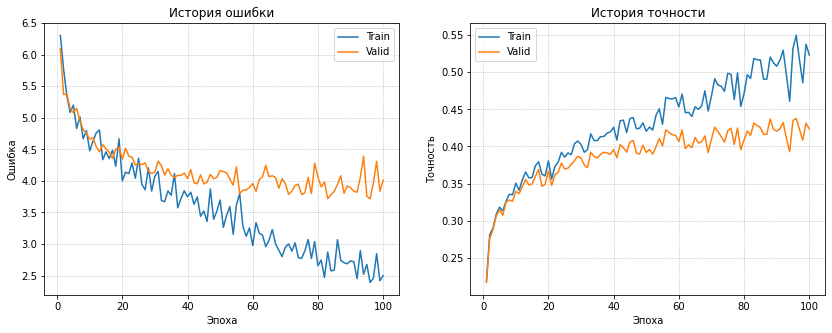

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 4.0766
Точность на тесте: 0.4239
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.45      0.55      0.50      1000
           1       0.61      0.47      0.53      1000
           2       0.25      0.31      0.28      1000
           3       0.31      0.18      0.23      1000
           4       0.30      0.48      0.37      1000
           5       0.49      0.23      0.32      1000
           6       0.39      0.64      0.49      1000
           7       0.55      0.39      0.46      1000
           8       0.55      0.57      0.56      1000
           9       0.56      0.41      0.48      1000

    accuracy                           0.42     10000
   macro avg       0.45      0.42      0.42     10000


In [69]:
model = Sequential(
    Linear(3072, 2500),
    Sigmoid(),
    Linear(2500, 1500),
    Sigmoid(),
    Linear(1500, 512),
    Sigmoid(),
    Linear(512, 128),
    Sigmoid(),
    Linear(128, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=100, batch_size=3000, alpha1=0.0001, alpha2=0.0001)
start_train.run()

Видим, что лучшая точность без регуляризации, а с добавлением и увеличением коэффициентов регуляризации точность падает, а ошибка растёт. Также из последних двух экспериментов видно, что модель без регуляризации показывает точность выше, но переобучается и выходит по ошибке на валидационной выборке на плато, но при этом разница в ошибке небольшая, а в точности - уже существенная, поэтому стоит брать модель без регуляризации.

### Эксперимент 11 Финальная архитектура

Как выглядит ваша финальная модель?

#### Подберём lr

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.4500  | 0.3347  |  5.2838  | 0.3294  | 0.003226 |   6.9    |   6.9    |
| 2/15|  4.5396  | 0.3628  |  4.7267  | 0.3604  | 0.002381 |   8.2    |   15.0   |
| 3/15|  4.3954  | 0.3850  |  4.4776  | 0.3746  | 0.001478 |   9.1    |   24.2   |
| 4/15|  4.4638  | 0.3973  |  4.3287  | 0.3868  | 0.001807 |   9.0    |   33.2   |
| 5/15|  4.3854  | 0.4098  |  4.2344  | 0.3976  | 0.001009 |   11.3   |   44.4   |
| 6/15|  3.8253  | 0.4220  |  4.1366  | 0.4068  | 0.001016 |   14.6   |   59.1   |
| 7/15|  3.8188  | 0.4294  |  4.0741  | 0.4150  | 0.001889 |   18.4   |   77.5   |
| 8/15|  3.7217  | 0.4364  |  4.0165  | 0.4180  | 0.001996 |   19.3   |   96.8   |
| 9/15|  3.8659  | 0.4421  |  3.9643  | 0.4

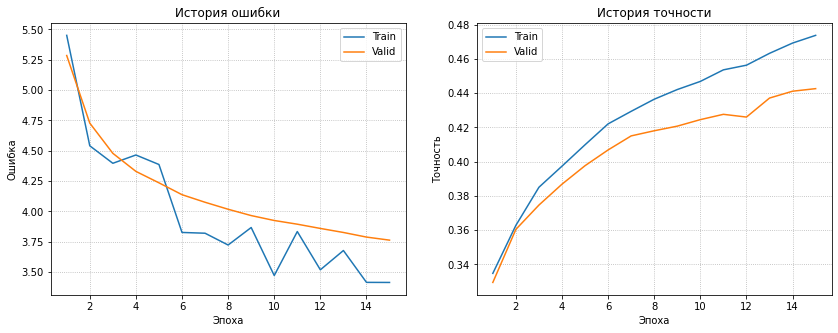

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.7623
Точность на тесте: 0.4415
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.55      0.47      0.51      1000
           1       0.54      0.50      0.52      1000
           2       0.33      0.26      0.29      1000
           3       0.29      0.38      0.33      1000
           4       0.39      0.35      0.37      1000
           5       0.39      0.34      0.36      1000
           6       0.44      0.53      0.48      1000
           7       0.49      0.47      0.48      1000
           8       0.52      0.62      0.57      1000
           9       0.48      0.50      0.49      1000

    accuracy                           0.44     10000
   macro avg       0.44      0.44      0.44     10000


In [47]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, lr=3e-4)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  4.7955  | 0.3438  |  4.9286  | 0.3361  | 0.019614 |   6.9    |   6.9    |
| 2/15|  4.1811  | 0.3825  |  4.4467  | 0.3663  | 0.013643 |   7.0    |   13.9   |                                               ] 0/1 0s>0s
| 3/15|  3.9664  | 0.4067  |  4.1857  | 0.3859  | 0.010684 |   7.3    |   21.2   |
| 4/15|  3.8979  | 0.4358  |  3.9739  | 0.4066  | 0.009508 |   7.2    |   28.5   |
| 5/15|  3.4665  | 0.4555  |  3.8182  | 0.4206  | 0.008883 |   7.4    |   35.9   |
| 6/15|  3.3362  | 0.4785  |  3.7117  | 0.4361  | 0.002825 |   8.2    |   44.1   |
| 7/15|  3.0955  | 0.4964  |  3.6415  | 0.4442  | 0.005904 |   9.3    |   53.4   |
| 8/15|  3.1124  | 0.5125  |  3.6076  | 0.4457  | 0.006217 |   10.3 

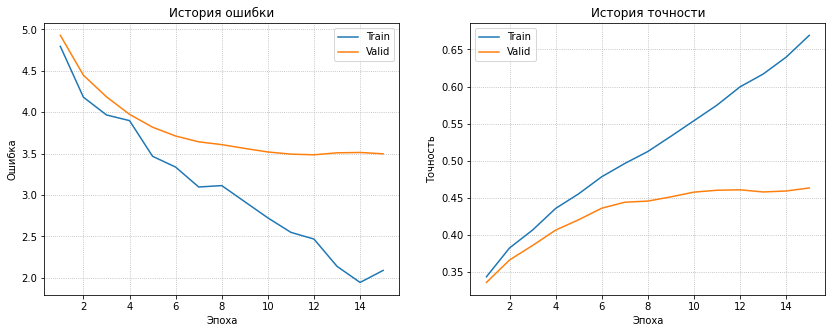

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.5194
Точность на тесте: 0.4705
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.51      0.57      0.53      1000
           1       0.61      0.51      0.55      1000
           2       0.36      0.35      0.36      1000
           3       0.33      0.34      0.33      1000
           4       0.37      0.44      0.40      1000
           5       0.36      0.41      0.38      1000
           6       0.51      0.53      0.52      1000
           7       0.57      0.45      0.51      1000
           8       0.60      0.61      0.60      1000
           9       0.57      0.49      0.53      1000

    accuracy                           0.47     10000
   macro avg       0.48      0.47      0.47     10000


In [48]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, lr=3e-3)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.3140  | 0.3554  |  4.8735  | 0.3470  | 0.006240 |   8.0    |   8.0    |
| 2/15|  4.7619  | 0.3851  |  4.4425  | 0.3763  | 0.005683 |   7.2    |   15.2   |
| 3/15|  3.8795  | 0.4113  |  4.1799  | 0.3964  | 0.002427 |   7.3    |   22.5   |
| 4/15|  3.8469  | 0.4326  |  4.0187  | 0.4118  | 0.004504 |   7.6    |   30.2   |
| 5/15|  3.4367  | 0.4501  |  3.8931  | 0.4313  | 0.001853 |   8.4    |   38.5   |
| 6/15|  3.5535  | 0.4617  |  3.8265  | 0.4328  | 0.003700 |   7.9    |   46.5   |
| 7/15|  3.4260  | 0.4717  |  3.7426  | 0.4391  | 0.002620 |   9.7    |   56.2   |
| 8/15|  3.4154  | 0.4893  |  3.6745  | 0.4510  | 0.002556 |   8.5    |   64.6   |
| 9/15|  3.4150  | 0.4970  |  3.6230  | 0.4

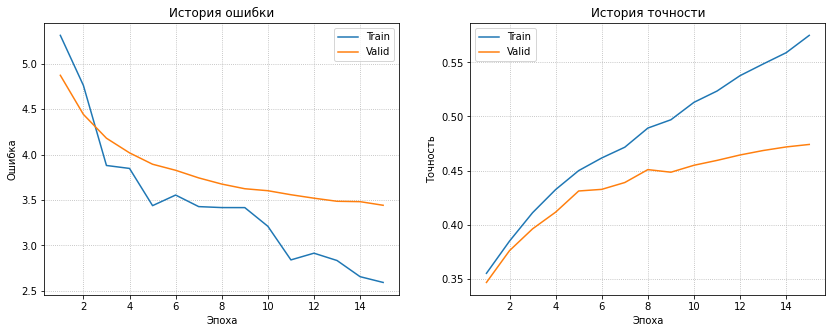

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4312
Точность на тесте: 0.4780
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.59      0.53      0.56      1000
           1       0.57      0.57      0.57      1000
           2       0.37      0.31      0.34      1000
           3       0.36      0.29      0.33      1000
           4       0.41      0.35      0.38      1000
           5       0.38      0.42      0.40      1000
           6       0.46      0.59      0.52      1000
           7       0.50      0.54      0.52      1000
           8       0.58      0.65      0.61      1000
           9       0.52      0.52      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000


In [70]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, lr=1e-3)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  4.8995  | 0.3463  |  4.9190  | 0.3408  | 0.002996 |   8.0    |   8.0    |
| 2/15|  4.1840  | 0.3881  |  4.4039  | 0.3802  | 0.003697 |   7.5    |   15.6   |
| 3/15|  4.2531  | 0.4118  |  4.1836  | 0.3979  | 0.002995 |   8.0    |   23.6   |
| 4/15|  4.0337  | 0.4249  |  4.0564  | 0.4063  | 0.001847 |   8.4    |   32.0   |
| 5/15|  3.8478  | 0.4395  |  3.9538  | 0.4146  | 0.002014 |   7.9    |   39.9   |
| 6/15|  3.8222  | 0.4546  |  3.8554  | 0.4303  | 0.002847 |   7.8    |   47.8   |
| 7/15|  3.5209  | 0.4638  |  3.7973  | 0.4320  | 0.002090 |   8.0    |   55.8   |
| 8/15|  3.3403  | 0.4743  |  3.7352  | 0.4411  | 0.002484 |   9.0    |   64.7   |
| 9/15|  3.2867  | 0.4837  |  3.6767  | 0.4

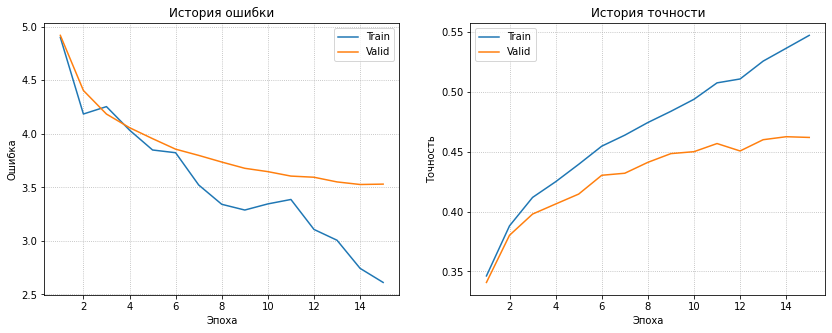

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.5373
Точность на тесте: 0.4689
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.58      0.55      0.56      1000
           1       0.59      0.53      0.56      1000
           2       0.36      0.32      0.34      1000
           3       0.32      0.36      0.34      1000
           4       0.38      0.33      0.35      1000
           5       0.40      0.33      0.36      1000
           6       0.45      0.62      0.52      1000
           7       0.56      0.47      0.51      1000
           8       0.59      0.62      0.60      1000
           9       0.49      0.55      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000


In [71]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000, lr=8e-4)
start_train.run()

Видим, что lr=1e-3 даёт наилучший результат (точность)

### Итоговая модель

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/50|  5.7922  | 0.2796  |  5.7653  | 0.2793  | 0.010815 |   9.5    |   9.5    |
| 2/50|  5.2179  | 0.3337  |  5.1276  | 0.3304  | 0.010166 |   10.1   |   19.6   |
| 3/50|  4.8094  | 0.3528  |  4.8572  | 0.3426  | 0.006056 |   13.2   |   32.8   |
| 4/50|  4.6898  | 0.3707  |  4.6562  | 0.3639  | 0.004616 |   11.1   |   43.9   |
| 5/50|  4.4440  | 0.3829  |  4.5198  | 0.3726  | 0.002349 |   11.4   |   55.4   |
| 6/50|  4.3955  | 0.3885  |  4.4012  | 0.3777  | 0.003024 |   11.9   |   67.2   |
| 7/50|  4.1538  | 0.3998  |  4.3034  | 0.3872  | 0.001475 |   11.3   |   78.5   |
| 8/50|  4.1338  | 0.4109  |  4.2290  | 0.3941  | 0.002000 |   11.6   |   90.2   |
| 9/50|  4.0663  | 0.4175  |  4.1614  | 0.4

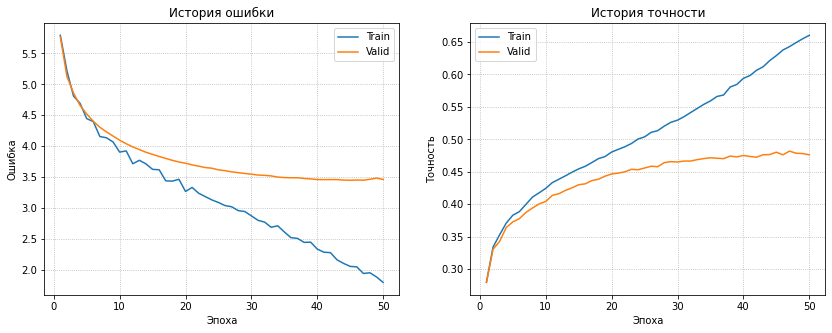

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4643
Точность на тесте: 0.4830
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.52      0.62      0.57      1000
           1       0.58      0.57      0.58      1000
           2       0.39      0.37      0.38      1000
           3       0.33      0.35      0.34      1000
           4       0.43      0.36      0.39      1000
           5       0.37      0.39      0.38      1000
           6       0.51      0.54      0.52      1000
           7       0.55      0.49      0.52      1000
           8       0.63      0.61      0.62      1000
           9       0.53      0.53      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000


In [74]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=50, optimizer="Adam", batch_size=10000)
start_train.run()

Видно, что loss на valid вышел на плато, а значит модель полностью обучилась. Модель с такой архитектурой показала наивысшую точность из всех экспериментов